## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

The images for camera calibration are stored in the folder called camera_cal.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [3]:
images

['camera_cal/calibration1.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration16.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration9.jpg']

In [4]:
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## 2. Apply a distortion correction to raw images.

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # undist = np.copy(img)  # Delete this line
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst,mtx,dist


OpenCV functions were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (calibration2.jpg).

The distortion matrix **(mtx)** is used to un-distort the calibration image. It can be seen in the undistorted image that the processing worked, as observed in the lack of a curvature in the top edge of the chessboard.

undistorting sample image:  camera_cal/calibration2.jpg


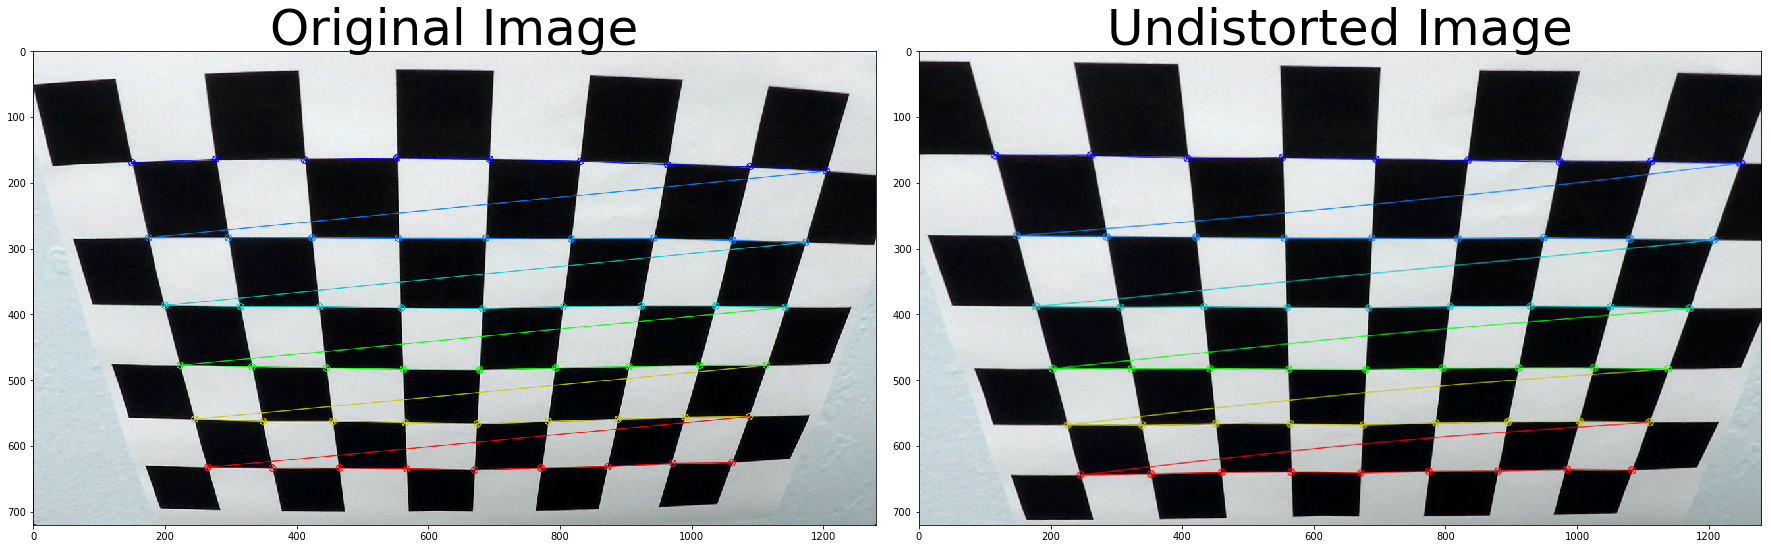

In [6]:
img = cv2.imread(images[11])
print('undistorting sample image: ',images[11])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

# If found, add object points, image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    img2 = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

undistorted,mtx,dist = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/distortion_correction_output.jpg',figsize=(1,1))

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

Described below is how I used color transforms, gradients or other methods to create a thresholded binary image. Provided is an example of a binary image result.

In [7]:
test_images = glob.glob('test_images/test*.jpg')
line_images = glob.glob('test_images/straight_lines*.jpg')
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

In [209]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = cv2.GaussianBlur(img,(5,5),0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    v_channel = hls[:,:,2]    
    
    # Explore gradients in other colors spaces / color channels to see what might work better
    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary,color_binary    

**Provided below are examples of binary image result.**

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

The code for my perspective transform includes a function called warper(), which appears in lines 1 through 8 in the file example.py (examples/example.py) . The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. I chose the hardcode the source and destination points in the following manner:



In [197]:
def warper(img, 
           src=np.float32([(545,485),
                  (735,485), 
                  (1065,695),
                  (245,695) 
                  ]), 
           dst = np.float32([(450,0),
                  (1200-450,0),
                  (1200-450,720),
                  (450,720)
                  ])
          ):

    # Compute and apply perpective transform
    # Return transform matrix
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    
    return warped,M,Minv


def undistort(img,mtx,dist):
    undistorted=cv2.undistort(img,mtx,dist,None,mtx)
    return undistorted

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


## 5. Detect lane pixels and fit to find the lane boundary.

In [225]:
def sliding_window(image=None,mtx=mtx,dist=dist, nwindows = 10,margin = 90,minpix = 50):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
    binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    

    # # Find the peak of the left and right halves of the histogram
    # # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,return_M,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    

In [226]:
def get_curvature(ploty,lefty,righty,leftx,rightx,
                  xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    #     lefty/righty is the actual pixel sample's y-value
    #     leftx/rightx is the actual pixel sample's x-value

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #     print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad,right_curverad


In [227]:
def return_line(orig_image,warped_image,left_fitx,right_fitx,ploty,return_M, left_curverad,right_curverad):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    color_warp=cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, return_M, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    
    
    new_img = np.copy(result)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature(L): ' + '{:04.2f}'.format(left_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    text = 'Radius of Curvature(R): ' + '{:04.2f}'.format(right_curverad) + 'm'
    cv2.putText(new_img, text, (40,120), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    return new_img


In [228]:
def update_lanes(image=None,mtx=mtx,dist=dist
                 , nwindows = 9,margin = 80
                 ,minpix = 50, left_fit_previous=[]
                 ,right_fit_previous=[]):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
#     binary_warped,stack_binary = pipeline(warped)
    binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    #         pipeline_binary,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     margin = 100
#     margin=60
    left_lane_inds = ((nonzerox > (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + 
    left_fit_previous[2] - margin)) & (nonzerox < (left_fit_previous[0]*(nonzeroy**2) + 
    left_fit_previous[1]*nonzeroy + left_fit_previous[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + 
    right_fit_previous[2] - margin)) & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) + 
    right_fit_previous[1]*nonzeroy + right_fit_previous[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return out_img,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    


In [246]:
# Define a class to receive the characteristics of each line detection
import numpy as np
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.fitx = None
        self.ploty = None
        
class Lane():
    def __init__(self):
        self.left_line = Line()
        self.right_line = Line()
        self.out_image = None
        self.inverse_M = None
        self.mtx = None
        self.image=None
        self.detected=False
    def get_curvature(self):
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ally, \
                                                     righty=self.right_line.ally,\
                                                     leftx=self.left_line.allx,\
                                                     rightx=self.right_line.allx)

    def set_lanelines(self):
        self.out_image= return_line(orig_image=self.image,warped_image=self.out_image, \
                                  left_fitx=self.left_line.fitx,right_fitx=self.right_line.fitx, \
                                  ploty=self.left_line.ploty,return_M=self.inverse_M, left_curverad=self.left_line.radius_of_curvature, \
                                  right_curverad=self.right_line.radius_of_curvature)
        
    def update(self,image):
#         self.image=image
        self.out_image,self.left_line, self.right_line = update_lines(image=image, \
                                          left_line=self.left_line, \
                                          right_line=self.right_line)
        self.get_curvature()
#         self.set_lanelines()
        
#         check threshold of curvature difference
        if((self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.right_line.radius_of_curvature <0.5):
            self.left_line.best_fit=self.left_line.current_fit
            self.right_line.best_fit=self.right_line.current_fit
            self.image=image
            self.detected=True
        else:
            self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
            left_line=self.left_line, \
            right_line=self.right_line)
            self.get_curvature()

        self.set_lanelines()


    def sliding_window(self,image):
        self.image=image
        self.out_image,self.inverse_M,self.left_line.fitx,self.right_line.fitx,\
            self.left_line.ploty,self.left_line.allx,self.left_line.ally,\
            self.right_line.allx,self.right_line.ally,self.left_line.current_fit,\
            self.right_line.current_fit = sliding_window(image)
        self.get_curvature()
#         self.set_lanelines()
        
#         check threshold of curvature difference
        if((self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.right_line.radius_of_curvature <0.5):
            self.left_line.best_fit=self.left_line.current_fit
            self.right_line.best_fit=self.right_line.current_fit
            self.image=image
            self.detected=True
        else:
            self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
            left_line=self.left_line, \
            right_line=self.right_line)
            self.get_curvature()

        self.set_lanelines
        

In [243]:
def update_lines(image=None,left_line=None,right_line=None):
    out_img,left_line.fitx,right_line.fitx, \
    left_line.ploty,left_line.allx, \
    left_line.ally,right_line.allx, \
    right_line.ally,left_line.current_fit, \
    right_line.current_fit = update_lanes( image, \
                                          left_fit_previous=left_line.current_fit, \
                                          right_fit_previous=right_line.current_fit) 
    return out_img,left_line, right_line

In [68]:
temp_lane = Lane()
temp_lane.sliding_window(mpimg.imread(line_images[1]))
# plt.figure()
# plt.imshow(temp_lane.out_image)
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)
# temp_lane.update(mpimg.imread(test_images[1]))
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)


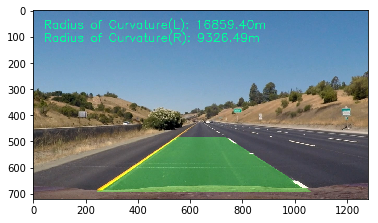

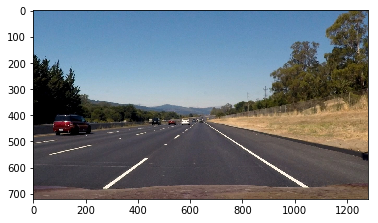

In [69]:
temp_lane.update(mpimg.imread(line_images[0]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(line_images[1]))

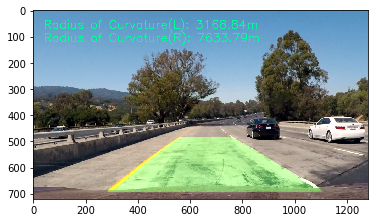

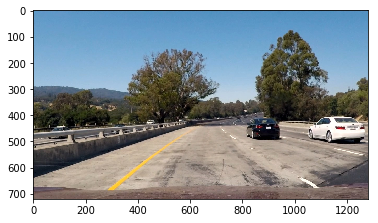

In [70]:
temp_lane.update(mpimg.imread(test_images[0]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(test_images[0]))

## Test on Videos

In [71]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [214]:
lane_container=Lane()

In [247]:
lane_container=Lane()
# lane_container.sliding_window(image)
lane_container.sliding_window(mpimg.imread(line_images[0]))
def process_image(image):
    try:
        if(lane_container.detected==True):
            lane_container.update(image)
        else:
            lane_container.sliding_window(image)
    except:
        try:
            lane_container.sliding_window(image) 
        except:
            pass
        else:
            pass
    else:
        pass
        
    l_fit_x_int = lane_container.left_line.fitx[image.shape[0]-1]
    r_fit_x_int = lane_container.right_line.fitx[image.shape[0]-1]
    print(l_fit_x_int, r_fit_x_int, r_fit_x_int - l_fit_x_int)
    
    if ((r_fit_x_int - l_fit_x_int)<450.0 ) and ((r_fit_x_int - l_fit_x_int)>250.0):
        
#         if(abs(R-R0)/R0>0.5)
        if((lane_container.left_line.radius_of_curvature-lane_container.right_line.radius_of_curvature)/ \
           lane_container.right_line.radius_of_curvature <0.5):
#        abs(R-R0)/R0  # R = current radius of curvature
            lane_container.left_line.best_fit=lane_container.left_line.current_fit
            lane_container.right_line.best_fit=lane_container.right_line.current_fit
            lane_container.detected=True
        else:
            lane_container.out_image=image
            lane_container.detected=False
    else:
        lane_container.out_image=image
        lane_container.detected=False
    
#     if ()
            
#         l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
#         r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
#         x_int_diff = abs(r_fit_x_int-l_fit_x_int)
#         if abs(350 - x_int_diff) > 100:
#             l_fit = None
#             r_fit = None
            
#     l_line.add_fit(l_fit, l_lane_inds)
#     r_line.add_fit(r_fit, r_lane_inds)
        
#     if (rn.rand()>0.80):
#         lane_container.sliding_window(image)
#     else:
#         lane_container.update(image)
    return lane_container.out_image

463.051493216 768.944795539 305.893302322


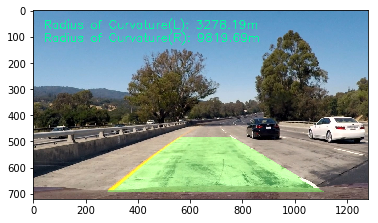

In [248]:
process_image(mpimg.imread(test_images[0]))
plt.imshow(lane_container.out_image)
# plt.imshow(temp_lane.out_image)
# plt.figure()
# plt.imshow(mpimg.imread(test_images[0]))

In [73]:
sample_output = 'sample_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

[MoviePy] >>>> Building video sample_output.mp4
[MoviePy] Writing video sample_output.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  9.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_output.mp4 

CPU times: user 3min 5s, sys: 21.9 s, total: 3min 27s
Wall time: 2min 18s


In [58]:
video = io.open('sample_output.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [74]:
from numpy import random as rn

In [132]:
sample_output = 'sample_output_withrand.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

720
475.005971369 779.946049143 304.940077774
[MoviePy] >>>> Building video sample_output_withrand.mp4
[MoviePy] Writing video sample_output_withrand.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

720



  0%|          | 1/1261 [00:00<02:55,  7.16it/s]

475.005971369 779.946049143 304.940077774
720



  0%|          | 2/1261 [00:00<02:51,  7.32it/s]

474.848182571 779.98922504 305.141042469
720



  0%|          | 3/1261 [00:00<02:54,  7.21it/s]

474.869954582 782.855265673 307.985311091
720



  0%|          | 4/1261 [00:00<02:51,  7.32it/s]

474.762588324 783.615833714 308.85324539
720



  0%|          | 5/1261 [00:00<02:46,  7.56it/s]

475.46937441 783.868876915 308.399502505
720



  0%|          | 6/1261 [00:00<02:45,  7.61it/s]

476.262583028 783.394753612 307.132170584
720



  1%|          | 7/1261 [00:00<02:43,  7.65it/s]

476.86141583 782.817920015 305.956504185
720



  1%|          | 8/1261 [00:01<02:52,  7.26it/s]

477.922301275 788.361401161 310.439099886
720



  1%|          | 9/1261 [00:01<03:02,  6.85it/s]

477.877736213 790.496861596 312.619125383
720



  1%|          | 10/1261 [00:01<03:05,  6.73it/s]

477.712494511 797.31721525 319.604720739
720



  1%|          | 11/1261 [00:01<02:57,  7.03it/s]

477.82322705 788.124569227 310.301342177
720



  1%|          | 12/1261 [00:01<02:59,  6.97it/s]

476.962971381 787.998383094 311.035411712
720



  1%|          | 13/1261 [00:01<03:04,  6.78it/s]

477.256575378 782.411434423 305.154859044
720



  1%|          | 14/1261 [00:01<02:55,  7.09it/s]

477.241394566 782.162229954 304.920835388
720



  1%|          | 15/1261 [00:02<02:51,  7.26it/s]

477.398249346 781.208718804 303.810469458
720



  1%|▏         | 16/1261 [00:02<02:49,  7.37it/s]

477.602004436 779.910758719 302.308754283
720



  1%|▏         | 17/1261 [00:02<02:44,  7.58it/s]

477.253136557 780.057195954 302.804059397
720



  1%|▏         | 18/1261 [00:02<02:42,  7.65it/s]

477.051285037 779.55133106 302.500046024
720



  2%|▏         | 19/1261 [00:02<02:47,  7.43it/s]

476.700728041 780.064707122 303.363979081
720



  2%|▏         | 20/1261 [00:02<02:46,  7.47it/s]

476.485990111 780.361142835 303.875152724
720


TypeError: expected non-empty vector for x

In [249]:
sample_output = 'sample_output_withrand_andgauss6.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

463.051493216 768.944795539 305.893302322
[MoviePy] >>>> Building video sample_output_withrand_andgauss6.mp4
[MoviePy] Writing video sample_output_withrand_andgauss6.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

463.051493216 768.944795539 305.893302322


  0%|          | 2/1261 [00:00<03:56,  5.33it/s]

463.051493216 768.944795539 305.893302322


  0%|          | 3/1261 [00:00<03:32,  5.91it/s]

474.869954582 782.855265673 307.985311091


  0%|          | 4/1261 [00:00<03:16,  6.40it/s]

474.762588324 783.615833714 308.85324539


  0%|          | 5/1261 [00:00<03:02,  6.88it/s]

475.46937441 783.868876915 308.399502505


  0%|          | 6/1261 [00:00<02:53,  7.24it/s]

476.262583028 783.394753612 307.132170584


  1%|          | 7/1261 [00:00<02:47,  7.49it/s]

476.86141583 782.817920015 305.956504185


  1%|          | 8/1261 [00:01<02:44,  7.64it/s]

477.922301275 788.361401161 310.439099886


  1%|          | 9/1261 [00:01<02:44,  7.62it/s]

477.877736213 790.496861596 312.619125383


  1%|          | 10/1261 [00:01<03:08,  6.65it/s]

477.877736213 790.496861596 312.619125383


  1%|          | 11/1261 [00:01<02:55,  7.11it/s]

477.82322705 788.124569227 310.301342177


  1%|          | 12/1261 [00:01<02:49,  7.38it/s]

476.962971381 787.998383094 311.035411712


  1%|          | 13/1261 [00:01<02:44,  7.58it/s]

477.256575378 782.411434423 305.154859044


  1%|          | 14/1261 [00:01<02:38,  7.89it/s]

477.241394566 782.162229954 304.920835388


  1%|          | 15/1261 [00:02<02:38,  7.84it/s]

477.398249346 781.208718804 303.810469458


  1%|▏         | 16/1261 [00:02<02:34,  8.05it/s]

477.602004436 779.910758719 302.308754283


  1%|▏         | 17/1261 [00:02<02:28,  8.37it/s]

477.253136557 780.057195954 302.804059397


  1%|▏         | 18/1261 [00:02<02:24,  8.61it/s]

477.051285037 779.55133106 302.500046024


  2%|▏         | 19/1261 [00:02<02:21,  8.81it/s]

476.700728041 780.064707122 303.363979081


  2%|▏         | 20/1261 [00:02<02:17,  9.01it/s]

476.485990111 780.361142835 303.875152724


  2%|▏         | 21/1261 [00:02<02:41,  7.66it/s]

476.485990111 780.361142835 303.875152724


  2%|▏         | 22/1261 [00:02<02:33,  8.07it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 23/1261 [00:03<02:54,  7.10it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 24/1261 [00:03<03:08,  6.56it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 25/1261 [00:03<03:16,  6.30it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 26/1261 [00:03<03:23,  6.06it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 27/1261 [00:03<03:27,  5.95it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 28/1261 [00:03<03:35,  5.72it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 29/1261 [00:04<03:31,  5.81it/s]

476.2333235 777.932964879 301.699641379


  2%|▏         | 30/1261 [00:04<03:10,  6.45it/s]

469.220004491 779.285444675 310.065440183


  2%|▏         | 31/1261 [00:04<02:51,  7.16it/s]

468.881093903 779.243027845 310.361933942


  3%|▎         | 32/1261 [00:04<02:44,  7.46it/s]

469.016772561 778.158129022 309.141356461


  3%|▎         | 33/1261 [00:04<02:32,  8.05it/s]

468.674477248 791.360044088 322.68556684


  3%|▎         | 34/1261 [00:04<02:54,  7.04it/s]

468.674477248 791.360044088 322.68556684


  3%|▎         | 36/1261 [00:05<03:29,  5.85it/s]

468.674477248 791.360044088 322.68556684
468.674477248 791.360044088 322.68556684


  3%|▎         | 37/1261 [00:05<03:38,  5.59it/s]

468.674477248 791.360044088 322.68556684


  3%|▎         | 39/1261 [00:05<03:20,  6.09it/s]

468.674477248 791.360044088 322.68556684
472.510821749 777.300861465 304.790039716


  3%|▎         | 41/1261 [00:05<02:59,  6.81it/s]

472.510821749 777.300861465 304.790039716
472.596742451 778.376942565 305.780200114


  3%|▎         | 43/1261 [00:06<02:50,  7.14it/s]

472.596742451 778.376942565 305.780200114
473.408950242 778.638857672 305.22990743


  4%|▎         | 45/1261 [00:06<02:28,  8.19it/s]

473.284997496 778.559491202 305.274493706
473.414896059 779.263321256 305.848425197


  4%|▎         | 47/1261 [00:06<02:18,  8.76it/s]

473.349859906 797.419348194 324.069488288
473.066399241 786.117791857 313.051392616


  4%|▍         | 49/1261 [00:06<02:37,  7.69it/s]

473.545754584 783.239024472 309.693269888
473.545754584 783.239024472 309.693269888


  4%|▍         | 51/1261 [00:07<03:04,  6.56it/s]

473.545754584 783.239024472 309.693269888
473.545754584 783.239024472 309.693269888


  4%|▍         | 53/1261 [00:07<03:15,  6.16it/s]

473.545754584 783.239024472 309.693269888
473.545754584 783.239024472 309.693269888


  4%|▍         | 55/1261 [00:07<02:58,  6.76it/s]

473.545754584 783.239024472 309.693269888
474.02597372 778.162017015 304.136043295


  5%|▍         | 57/1261 [00:08<02:31,  7.93it/s]

473.851905669 778.394982873 304.543077204
473.894108397 778.759026315 304.864917917


  5%|▍         | 59/1261 [00:08<02:43,  7.33it/s]

473.601047276 777.634354434 304.033307158
473.601047276 777.634354434 304.033307158


  5%|▍         | 61/1261 [00:08<03:08,  6.37it/s]

473.601047276 777.634354434 304.033307158
473.601047276 777.634354434 304.033307158


  5%|▍         | 63/1261 [00:09<03:18,  6.02it/s]

473.601047276 777.634354434 304.033307158
473.601047276 777.634354434 304.033307158


  5%|▌         | 65/1261 [00:09<03:25,  5.82it/s]

473.601047276 777.634354434 304.033307158
473.601047276 777.634354434 304.033307158


  5%|▌         | 67/1261 [00:09<03:01,  6.58it/s]

473.601047276 777.634354434 304.033307158
469.984338946 771.972775676 301.98843673


  5%|▌         | 69/1261 [00:09<02:34,  7.72it/s]

468.272180584 772.024438604 303.75225802
467.554370822 770.89950165 303.345130828


  6%|▌         | 71/1261 [00:10<02:23,  8.28it/s]

466.47652892 770.660483845 304.183954925
466.110859637 766.038790233 299.927930596


  6%|▌         | 73/1261 [00:10<02:34,  7.68it/s]

466.110859637 766.038790233 299.927930596
465.268877124 776.832623121 311.563745996


  6%|▌         | 75/1261 [00:10<02:21,  8.41it/s]

465.525449707 765.300636309 299.775186602
465.031699116 768.674482835 303.642783719


  6%|▌         | 77/1261 [00:10<02:39,  7.43it/s]

465.76931967 766.135900289 300.366580619
465.76931967 766.135900289 300.366580619


  6%|▋         | 79/1261 [00:11<02:47,  7.05it/s]

465.084801199 768.08167963 302.996878431
465.084801199 768.08167963 302.996878431


  6%|▋         | 81/1261 [00:11<02:29,  7.92it/s]

464.570546674 767.67280252 303.102255846
464.088088974 767.621433425 303.533344451


  7%|▋         | 83/1261 [00:11<02:58,  6.59it/s]

464.088088974 767.621433425 303.533344451
464.088088974 767.621433425 303.533344451


  7%|▋         | 85/1261 [00:12<02:57,  6.62it/s]

460.746876346 776.56695491 315.820078564
460.746876346 776.56695491 315.820078564


  7%|▋         | 87/1261 [00:12<03:14,  6.05it/s]

460.746876346 776.56695491 315.820078564
460.746876346 776.56695491 315.820078564


  7%|▋         | 89/1261 [00:12<03:21,  5.81it/s]

460.746876346 776.56695491 315.820078564
460.746876346 776.56695491 315.820078564


  7%|▋         | 91/1261 [00:13<03:07,  6.23it/s]

459.709155203 765.853094373 306.14393917
459.709155203 765.853094373 306.14393917


  7%|▋         | 93/1261 [00:13<02:37,  7.43it/s]

460.176839219 766.576835492 306.399996273
460.280933035 766.594928343 306.313995308


  8%|▊         | 95/1261 [00:13<02:23,  8.12it/s]

460.589518009 766.463462833 305.873944823
460.073503738 766.137562934 306.064059196


  8%|▊         | 97/1261 [00:13<02:41,  7.23it/s]

460.259351849 756.269811444 296.010459595
460.259351849 756.269811444 296.010459595


  8%|▊         | 99/1261 [00:14<02:38,  7.31it/s]

460.259351849 756.269811444 296.010459595
461.635672467 770.606380099 308.970707632


  8%|▊         | 101/1261 [00:14<02:38,  7.33it/s]

461.635672467 770.606380099 308.970707632
462.931218313 760.079990882 297.148772569


  8%|▊         | 103/1261 [00:14<02:42,  7.12it/s]

463.55098374 759.487130557 295.936146816
463.55098374 759.487130557 295.936146816


  8%|▊         | 105/1261 [00:14<02:25,  7.95it/s]

464.73625151 763.559429186 298.823177677
464.975247878 766.188935651 301.213687773


  8%|▊         | 107/1261 [00:15<02:20,  8.23it/s]

464.974011231 767.241798109 302.267786878
464.980118544 768.894890562 303.914772018


  9%|▊         | 109/1261 [00:15<02:33,  7.51it/s]

464.980118544 768.894890562 303.914772018
465.790652652 783.982754241 318.192101589


  9%|▉         | 111/1261 [00:15<02:42,  7.06it/s]

465.790930122 772.764224182 306.973294059
465.790930122 772.764224182 306.973294059


  9%|▉         | 113/1261 [00:16<02:45,  6.95it/s]

465.790930122 772.764224182 306.973294059
466.584906669 774.431188566 307.846281897


  9%|▉         | 115/1261 [00:16<02:38,  7.21it/s]

466.584906669 774.431188566 307.846281897
467.716070328 772.689733112 304.973662785


  9%|▉         | 117/1261 [00:16<02:35,  7.37it/s]

467.716070328 772.689733112 304.973662785
468.248937952 772.312377314 304.063439362


  9%|▉         | 119/1261 [00:16<02:20,  8.15it/s]

468.701606876 772.144839898 303.443233022
468.968535402 772.292503058 303.323967656


 10%|▉         | 121/1261 [00:17<02:13,  8.57it/s]

469.768732047 772.080986794 302.312254747
470.596947333 772.052243317 301.455295983


 10%|▉         | 123/1261 [00:17<02:25,  7.83it/s]

470.596947333 772.052243317 301.455295983
471.749435615 779.552491886 307.803056271


 10%|▉         | 125/1261 [00:17<02:54,  6.52it/s]

471.749435615 779.552491886 307.803056271
471.749435615 779.552491886 307.803056271


 10%|█         | 127/1261 [00:17<02:57,  6.38it/s]

472.949148457 772.651204661 299.702056203
472.949148457 772.651204661 299.702056203


 10%|█         | 129/1261 [00:18<02:48,  6.70it/s]

472.949148457 772.651204661 299.702056203
474.698744734 774.656648644 299.95790391


 10%|█         | 131/1261 [00:18<02:26,  7.72it/s]

474.586551663 774.940803918 300.354252255
474.697285712 775.331327229 300.634041517


 11%|█         | 133/1261 [00:18<02:20,  8.05it/s]

475.132512697 775.495651887 300.36313919
475.663174894 776.340396802 300.677221907


 11%|█         | 135/1261 [00:19<02:49,  6.64it/s]

475.663174894 776.340396802 300.677221907
475.663174894 776.340396802 300.677221907


 11%|█         | 137/1261 [00:19<02:54,  6.42it/s]

475.663174894 776.340396802 300.677221907
477.677054131 780.271712967 302.594658836


 11%|█         | 139/1261 [00:19<02:45,  6.76it/s]

477.677054131 780.271712967 302.594658836
476.854974246 782.772062571 305.917088325


 11%|█         | 141/1261 [00:19<02:25,  7.70it/s]

476.40335654 779.607712919 303.204356379
476.290931329 780.840318945 304.549387616


 11%|█▏        | 143/1261 [00:20<02:29,  7.48it/s]

476.290931329 780.840318945 304.549387616
475.686172626 779.806046728 304.119874102


 11%|█▏        | 145/1261 [00:20<02:17,  8.09it/s]

474.975634543 778.640558226 303.664923683
474.43410091 778.891355625 304.457254715


 12%|█▏        | 147/1261 [00:20<02:37,  7.06it/s]

474.27868922 778.679140337 304.400451117
474.27868922 778.679140337 304.400451117


 12%|█▏        | 149/1261 [00:21<02:47,  6.64it/s]

474.715998049 772.237403514 297.521405464
474.715998049 772.237403514 297.521405464


 12%|█▏        | 151/1261 [00:21<02:27,  7.53it/s]

475.219958457 781.548092177 306.32813372
474.873328079 777.837819749 302.964491671


 12%|█▏        | 153/1261 [00:21<02:39,  6.96it/s]

474.499529997 780.824593046 306.325063049
474.499529997 780.824593046 306.325063049


 12%|█▏        | 155/1261 [00:21<02:55,  6.30it/s]

474.499529997 780.824593046 306.325063049
474.499529997 780.824593046 306.325063049


 12%|█▏        | 157/1261 [00:22<02:32,  7.23it/s]

473.809610315 777.946099999 304.136489684
473.218037002 777.441124991 304.223087989


 13%|█▎        | 159/1261 [00:22<02:57,  6.21it/s]

473.218037002 777.441124991 304.223087989
473.218037002 777.441124991 304.223087989


 13%|█▎        | 161/1261 [00:22<03:10,  5.78it/s]

473.218037002 777.441124991 304.223087989
473.218037002 777.441124991 304.223087989


 13%|█▎        | 163/1261 [00:23<02:53,  6.34it/s]

469.029652362 781.066087718 312.036435357
469.029652362 781.066087718 312.036435357


 13%|█▎        | 165/1261 [00:23<02:56,  6.20it/s]

469.029652362 781.066087718 312.036435357
469.029652362 781.066087718 312.036435357


 13%|█▎        | 167/1261 [00:23<02:28,  7.36it/s]

468.428011306 775.187466115 306.759454809
468.725254713 775.203141257 306.477886544


 13%|█▎        | 169/1261 [00:24<02:30,  7.24it/s]

468.269547212 776.333287333 308.063740121
468.269547212 776.196196832 307.926649621


 14%|█▎        | 171/1261 [00:24<02:13,  8.20it/s]

466.712443486 775.602896571 308.890453085
466.277731967 786.791746536 320.514014569


 14%|█▍        | 174/1261 [00:24<02:18,  7.86it/s]

466.019370577 767.169034249 301.149663672
465.641183927 775.507270636 309.866086708
465.641183927 775.507270636 309.866086708


 14%|█▍        | 176/1261 [00:24<02:07,  8.53it/s]

465.93712439 767.320055767 301.382931377
465.496416777 773.740514651 308.244097874


 14%|█▍        | 178/1261 [00:25<02:40,  6.77it/s]

465.496416777 773.740514651 308.244097874
465.496416777 773.740514651 308.244097874


 14%|█▍        | 180/1261 [00:25<02:31,  7.14it/s]

465.496416777 773.740514651 308.244097874
464.966697973 773.180294395 308.213596422


 14%|█▍        | 182/1261 [00:25<02:53,  6.22it/s]

464.966697973 773.180294395 308.213596422
464.966697973 773.180294395 308.213596422


 15%|█▍        | 184/1261 [00:26<02:56,  6.11it/s]

464.966697973 773.180294395 308.213596422
464.966697973 773.180294395 308.213596422


 15%|█▍        | 186/1261 [00:26<02:44,  6.54it/s]

463.237537214 778.017733504 314.78019629
463.237537214 778.017733504 314.78019629


 15%|█▍        | 188/1261 [00:26<02:35,  6.90it/s]

463.237537214 778.017733504 314.78019629
463.220639758 772.765917789 309.545278031


 15%|█▌        | 190/1261 [00:26<02:13,  8.02it/s]

463.533888719 772.058929618 308.525040898
464.467282282 775.29403611 310.826753828


 15%|█▌        | 192/1261 [00:27<02:04,  8.60it/s]

466.286971621 774.42686657 308.139894949
467.574340645 775.352609818 307.778269173


 15%|█▌        | 194/1261 [00:27<02:19,  7.66it/s]

469.534673224 775.595249746 306.060576522
469.534673224 775.595249746 306.060576522


 16%|█▌        | 196/1261 [00:27<02:05,  8.50it/s]

471.466261389 775.310364557 303.844103168
470.588604367 775.067231227 304.47862686


 16%|█▌        | 198/1261 [00:27<02:18,  7.65it/s]

469.15897886 782.783455314 313.624476454
469.15897886 782.783455314 313.624476454


 16%|█▌        | 200/1261 [00:28<02:18,  7.67it/s]

469.15897886 782.783455314 313.624476454
466.254165054 784.703719709 318.449554655


 16%|█▌        | 203/1261 [00:28<02:20,  7.52it/s]

465.119094357 782.251500618 317.132406261
464.653846292 779.088940304 314.435094012
464.653846292 779.088940304 314.435094012


 16%|█▋        | 205/1261 [00:28<02:23,  7.36it/s]

464.653846292 779.088940304 314.435094012
464.114529525 775.867817102 311.753287576


 16%|█▋        | 207/1261 [00:29<02:11,  8.01it/s]

464.554811964 775.50577185 310.950959886
465.659907134 774.538818667 308.878911533


 17%|█▋        | 209/1261 [00:29<02:31,  6.93it/s]

466.472858258 778.252703425 311.779845167
466.472858258 778.252703425 311.779845167


 17%|█▋        | 211/1261 [00:29<02:54,  6.01it/s]

466.472858258 778.252703425 311.779845167
466.472858258 778.252703425 311.779845167


 17%|█▋        | 213/1261 [00:30<02:51,  6.12it/s]

466.169779378 782.554303758 316.38452438
466.169779378 782.554303758 316.38452438


 17%|█▋        | 215/1261 [00:30<02:59,  5.82it/s]

466.169779378 782.554303758 316.38452438
466.169779378 782.554303758 316.38452438


 17%|█▋        | 217/1261 [00:30<02:42,  6.41it/s]

466.169779378 782.554303758 316.38452438
462.693905639 772.909000182 310.215094543


 17%|█▋        | 219/1261 [00:30<02:14,  7.74it/s]

461.951055809 772.294706412 310.343650603
462.309607543 771.222803794 308.913196251


 18%|█▊        | 221/1261 [00:31<02:27,  7.06it/s]

462.572808165 771.332514442 308.759706277
462.572808165 771.332514442 308.759706277


 18%|█▊        | 223/1261 [00:31<02:23,  7.23it/s]

462.572808165 771.332514442 308.759706277
463.840487921 781.932936489 318.092448568


 18%|█▊        | 225/1261 [00:31<02:31,  6.85it/s]

464.479971929 771.372530389 306.89255846
464.479971929 771.372530389 306.89255846


 18%|█▊        | 227/1261 [00:32<02:12,  7.78it/s]

463.592567868 769.882164805 306.289596937
462.927602695 769.899979057 306.972376362


 18%|█▊        | 229/1261 [00:32<02:02,  8.41it/s]

462.628375158 768.375232577 305.74685742
461.771456792 767.562486409 305.791029617


 18%|█▊        | 231/1261 [00:32<02:00,  8.58it/s]

460.995781611 766.746378317 305.750596707
460.888305944 764.918994821 304.030688877


 18%|█▊        | 233/1261 [00:32<02:17,  7.50it/s]

459.909825928 763.734760541 303.824934614
459.909825928 763.734760541 303.824934614


 19%|█▊        | 235/1261 [00:33<02:45,  6.20it/s]

459.909825928 763.734760541 303.824934614
459.909825928 763.734760541 303.824934614


 19%|█▉        | 237/1261 [00:33<02:55,  5.84it/s]

459.909825928 763.734760541 303.824934614
459.909825928 763.734760541 303.824934614


 19%|█▉        | 239/1261 [00:33<02:57,  5.77it/s]

459.909825928 763.734760541 303.824934614
459.909825928 763.734760541 303.824934614


 19%|█▉        | 241/1261 [00:34<02:23,  7.12it/s]

456.092649996 759.952912908 303.860262911
455.603089933 759.839130945 304.236041013


 19%|█▉        | 243/1261 [00:34<02:05,  8.09it/s]

454.466722404 760.884553677 306.417831273
454.360990297 760.255249582 305.894259285


 19%|█▉        | 245/1261 [00:34<01:59,  8.52it/s]

453.486497025 759.800864094 306.314367069
453.034242904 762.702923279 309.668680375


 20%|█▉        | 247/1261 [00:34<02:07,  7.97it/s]

453.034242904 762.702923279 309.668680375
452.017383509 762.239273752 310.221890243


 20%|█▉        | 249/1261 [00:35<02:24,  6.98it/s]

452.422915727 765.250334339 312.827418612
452.422915727 765.250334339 312.827418612


 20%|█▉        | 251/1261 [00:35<02:45,  6.08it/s]

452.422915727 765.250334339 312.827418612
452.422915727 765.250334339 312.827418612


 20%|██        | 253/1261 [00:35<02:32,  6.61it/s]

452.422915727 765.250334339 312.827418612
451.853757922 758.703005955 306.849248034


 20%|██        | 255/1261 [00:35<02:13,  7.51it/s]

451.630512564 759.9603934 308.329880836
451.924245581 759.109602405 307.185356824


 20%|██        | 257/1261 [00:36<02:03,  8.12it/s]

451.560319738 758.931363337 307.371043598
451.623172186 781.680466577 330.057294392


 21%|██        | 259/1261 [00:36<02:18,  7.21it/s]

451.896117333 754.120632132 302.224514799
451.896117333 754.120632132 302.224514799


 21%|██        | 261/1261 [00:36<02:40,  6.23it/s]

451.896117333 754.120632132 302.224514799
451.896117333 754.120632132 302.224514799


 21%|██        | 263/1261 [00:37<02:49,  5.88it/s]

451.896117333 754.120632132 302.224514799
451.896117333 754.120632132 302.224514799


 21%|██        | 266/1261 [00:37<02:30,  6.63it/s]

451.896117333 9625.16293853 9173.2668212
453.899837747 762.745237594 308.845399847
452.812589682 762.617630147 309.805040465


 21%|██▏       | 268/1261 [00:37<02:11,  7.58it/s]

453.036020656 762.873941783 309.837921127
452.313574699 762.352282209 310.03870751


 21%|██▏       | 270/1261 [00:38<02:24,  6.87it/s]

451.434274082 764.492674779 313.058400697
451.434274082 763.082480501 311.648206419


 22%|██▏       | 272/1261 [00:38<02:33,  6.43it/s]

452.105965965 765.337316589 313.231350624
452.105965965 765.337316589 313.231350624


 22%|██▏       | 274/1261 [00:38<02:46,  5.93it/s]

452.105965965 765.337316589 313.231350624
452.105965965 765.337316589 313.231350624


 22%|██▏       | 276/1261 [00:39<02:32,  6.47it/s]

452.105965965 765.337316589 313.231350624
455.26458833 766.257029783 310.992441453


 22%|██▏       | 278/1261 [00:39<02:10,  7.54it/s]

455.454035663 766.439326944 310.985291281
455.423389402 766.758658209 311.335268807


 22%|██▏       | 280/1261 [00:39<02:01,  8.07it/s]

456.160364571 765.675301422 309.51493685
456.64752331 765.055866862 308.408343552


 22%|██▏       | 282/1261 [00:39<02:23,  6.83it/s]

456.64752331 765.055866862 308.408343552
456.64752331 765.055866862 308.408343552


 23%|██▎       | 284/1261 [00:40<02:35,  6.30it/s]

456.64752331 765.055866862 308.408343552
456.64752331 765.055866862 308.408343552


 23%|██▎       | 286/1261 [00:40<02:08,  7.61it/s]

459.814699613 769.364471757 309.549772144
459.708401024 769.631216908 309.922815884


 23%|██▎       | 288/1261 [00:40<01:55,  8.41it/s]

460.215849313 769.397485522 309.181636209
460.184767886 771.283798745 311.099030859


 23%|██▎       | 290/1261 [00:40<01:48,  8.97it/s]

461.117483679 770.852508877 309.735025198
461.257386631 771.382064651 310.124678021


 23%|██▎       | 292/1261 [00:41<01:44,  9.28it/s]

462.017042143 771.013830392 308.996788249
462.767983041 770.651848615 307.883865574


 23%|██▎       | 294/1261 [00:41<02:16,  7.06it/s]

462.767983041 770.651848615 307.883865574
462.767983041 770.651848615 307.883865574


 23%|██▎       | 296/1261 [00:41<02:33,  6.29it/s]

462.767983041 770.651848615 307.883865574
462.767983041 770.651848615 307.883865574


 24%|██▎       | 298/1261 [00:41<02:06,  7.64it/s]

464.362148257 771.506465238 307.144316981
464.412203416 770.971090995 306.558887579


 24%|██▍       | 300/1261 [00:42<02:26,  6.54it/s]

464.412203416 770.971090995 306.558887579
464.412203416 770.971090995 306.558887579


 24%|██▍       | 302/1261 [00:42<02:04,  7.69it/s]

463.786519757 772.496193012 308.709673255
463.091651093 772.86038702 309.768735927


 24%|██▍       | 304/1261 [00:42<01:53,  8.43it/s]

462.748279437 773.058237588 310.309958151
462.587296433 772.409050371 309.821753939


 24%|██▍       | 306/1261 [00:43<02:17,  6.94it/s]

462.587296433 772.409050371 309.821753939
462.587296433 772.409050371 309.821753939


 24%|██▍       | 308/1261 [00:43<02:17,  6.92it/s]

462.695191288 774.221129373 311.525938085
462.695191288 774.221129373 311.525938085


 25%|██▍       | 310/1261 [00:43<02:28,  6.38it/s]

462.695191288 774.221129373 311.525938085
462.695191288 774.221129373 311.525938085


 25%|██▍       | 312/1261 [00:44<02:37,  6.03it/s]

462.695191288 774.221129373 311.525938085
462.695191288 774.221129373 311.525938085


 25%|██▍       | 314/1261 [00:44<02:41,  5.87it/s]

462.695191288 774.221129373 311.525938085
462.695191288 774.221129373 311.525938085


 25%|██▌       | 316/1261 [00:44<02:23,  6.60it/s]

462.695191288 774.221129373 311.525938085
467.210824604 771.979882886 304.769058282


 25%|██▌       | 318/1261 [00:45<02:32,  6.19it/s]

467.210824604 771.979882886 304.769058282
467.210824604 771.979882886 304.769058282


 25%|██▌       | 320/1261 [00:45<02:34,  6.07it/s]

467.210824604 771.979882886 304.769058282
467.210824604 771.979882886 304.769058282


 26%|██▌       | 322/1261 [00:45<02:24,  6.50it/s]

467.210824604 771.979882886 304.769058282
468.927882519 767.963786394 299.035903875


 26%|██▌       | 324/1261 [00:46<02:37,  5.95it/s]

468.927882519 767.963786394 299.035903875
468.927882519 767.963786394 299.035903875


 26%|██▌       | 326/1261 [00:46<02:35,  6.03it/s]

468.927882519 767.963786394 299.035903875
468.927882519 767.963786394 299.035903875


 26%|██▌       | 328/1261 [00:46<02:35,  5.98it/s]

468.927882519 767.963786394 299.035903875
468.927882519 767.963786394 299.035903875


 26%|██▌       | 330/1261 [00:47<02:36,  5.93it/s]

468.927882519 767.963786394 299.035903875
468.927882519 767.963786394 299.035903875


 26%|██▋       | 332/1261 [00:47<02:33,  6.03it/s]

468.927882519 767.963786394 299.035903875
468.927882519 767.963786394 299.035903875


 26%|██▋       | 334/1261 [00:47<02:17,  6.74it/s]

468.927882519 767.963786394 299.035903875
467.699482876 770.114580194 302.415097319
467.986709592

 27%|██▋       | 337/1261 [00:48<02:19,  6.63it/s]

 771.358338876 303.371629284
467.986709592 771.358338876 303.371629284
467.986709592 771.358338876 303.371629284


 27%|██▋       | 339/1261 [00:48<02:25,  6.33it/s]

467.986709592 771.358338876 303.371629284
467.986709592 771.358338876 303.371629284


 27%|██▋       | 341/1261 [00:48<02:29,  6.16it/s]

467.986709592 771.358338876 303.371629284
467.986709592 771.358338876 303.371629284


 27%|██▋       | 343/1261 [00:49<02:28,  6.17it/s]

467.986709592 771.358338876 303.371629284
467.986709592 771.358338876 303.371629284


 27%|██▋       | 345/1261 [00:49<02:14,  6.81it/s]

467.986709592 771.358338876 303.371629284
468.539342125 770.993895162 302.454553038


 28%|██▊       | 347/1261 [00:49<02:24,  6.31it/s]

468.539342125 770.993895162 302.454553038
468.539342125 770.993895162 302.454553038


 28%|██▊       | 349/1261 [00:49<02:10,  6.97it/s]

468.539342125 770.993895162 302.454553038
469.602109641 773.202510702 303.600401061
469.407206715

 28%|██▊       | 352/1261 [00:50<01:52,  8.11it/s]

 773.671868885 304.26466217
469.223342721 773.620971894 304.397629172
468.854681122 774.159868419 305.305187297
467.935264858

 28%|██▊       | 355/1261 [00:50<02:04,  7.28it/s]

 774.533103728 306.59783887
467.935264858 774.533103728 306.59783887
467.935264858 774.533103728 306.59783887


 28%|██▊       | 357/1261 [00:51<02:17,  6.57it/s]

467.935264858 774.533103728 306.59783887
467.935264858 774.533103728 306.59783887


 28%|██▊       | 359/1261 [00:51<02:23,  6.27it/s]

467.935264858 774.533103728 306.59783887
467.935264858 774.52380856 306.588543702


 29%|██▊       | 361/1261 [00:51<01:58,  7.60it/s]

467.233075076 773.340340841 306.107265765
467.701855529 773.257826446 305.555970917


 29%|██▉       | 363/1261 [00:51<01:48,  8.30it/s]

468.420537703 772.3150566 303.894518897
469.203918724 773.059003076 303.855084353


 29%|██▉       | 365/1261 [00:52<01:55,  7.77it/s]

470.328651524 772.166580751 301.837929227
470.328651524 772.166580751 301.837929227


 29%|██▉       | 367/1261 [00:52<02:14,  6.67it/s]

470.328651524 772.166580751 301.837929227
470.328651524 772.166580751 301.837929227


 29%|██▉       | 369/1261 [00:52<02:19,  6.41it/s]

470.328651524 772.166580751 301.837929227
470.328651524 772.166580751 301.837929227


 29%|██▉       | 371/1261 [00:53<02:23,  6.20it/s]

470.328651524 772.166580751 301.837929227
470.328651524 772.285238469 301.956586945


 30%|██▉       | 373/1261 [00:53<02:08,  6.89it/s]

470.328651524 772.166580751 301.837929227
470.268743347 774.394229919 304.125486572
469.142001075

 30%|██▉       | 376/1261 [00:53<02:10,  6.77it/s]

 773.505974048 304.363972973
469.142001075 773.505974048 304.363972973
469.142001075 773.505974048 304.363972973


 30%|██▉       | 378/1261 [00:54<02:21,  6.24it/s]

469.142001075 773.505974048 304.363972973
469.142001075 773.505974048 304.363972973


 30%|███       | 380/1261 [00:54<02:26,  6.00it/s]

469.142001075 773.505974048 304.363972973
469.142001075 773.505974048 304.363972973


 30%|███       | 382/1261 [00:54<02:25,  6.03it/s]

469.142001075 773.505974048 304.363972973
469.142001075 773.538119912 304.396118837


 30%|███       | 384/1261 [00:55<02:21,  6.20it/s]

469.142001075 774.215460867 305.073459792
464.40085492 773.436284395 309.035429476


 31%|███       | 386/1261 [00:55<02:12,  6.59it/s]

464.754252614 772.967813353 308.213560739
464.198289606 773.217065331 309.018775724


 31%|███       | 389/1261 [00:55<01:59,  7.29it/s]

463.934713433 773.507629682 309.572916248
464.393711641 773.15359746 308.759885819
464.401406676 775.201908577 310.800501901


 31%|███       | 391/1261 [00:56<02:15,  6.43it/s]

464.401406676 775.201908577 310.800501901
464.401406676 775.201908577 310.800501901


 31%|███       | 393/1261 [00:56<02:21,  6.12it/s]

464.401406676 775.201908577 310.800501901
464.401406676 775.201908577 310.800501901


 31%|███▏      | 395/1261 [00:56<02:29,  5.80it/s]

464.401406676 775.201908577 310.800501901
464.401406676 775.201908577 310.800501901


 31%|███▏      | 397/1261 [00:57<02:12,  6.53it/s]

464.401406676 775.201908577 310.800501901
465.749541533 770.825029023 305.07548749


 32%|███▏      | 399/1261 [00:57<02:21,  6.09it/s]

465.749541533 770.825029023 305.07548749
465.749541533 770.825029023 305.07548749


 32%|███▏      | 401/1261 [00:57<02:25,  5.90it/s]

465.749541533 770.825029023 305.07548749
465.749541533 770.825029023 305.07548749


 32%|███▏      | 403/1261 [00:58<02:34,  5.54it/s]

465.749541533 770.825029023 305.07548749
465.749541533 770.825029023 305.07548749


 32%|███▏      | 405/1261 [00:58<02:16,  6.25it/s]

465.749541533 770.825029023 305.07548749
462.0378822 767.63781837 305.59993617


 32%|███▏      | 407/1261 [00:58<02:25,  5.87it/s]

462.0378822 767.63781837 305.59993617
462.0378822 767.63781837 305.59993617


 32%|███▏      | 409/1261 [00:59<02:24,  5.90it/s]

462.0378822 767.63781837 305.59993617
462.0378822 767.63781837 305.59993617


 33%|███▎      | 411/1261 [00:59<02:25,  5.84it/s]

462.0378822 767.63781837 305.59993617
462.0378822 767.63781837 305.59993617


 33%|███▎      | 413/1261 [00:59<02:14,  6.32it/s]

461.280887975 766.697624351 305.416736376
461.280887975 766.697624351 305.416736376


 33%|███▎      | 415/1261 [01:00<02:21,  5.99it/s]

461.280887975 766.697624351 305.416736376
461.280887975 766.697624351 305.416736376


 33%|███▎      | 417/1261 [01:00<02:23,  5.87it/s]

461.280887975 766.697624351 305.416736376
461.280887975 766.697624351 305.416736376


 33%|███▎      | 419/1261 [01:00<02:22,  5.91it/s]

461.280887975 766.694815481 305.413927506
461.280887975 766.776399048 305.495511074


 33%|███▎      | 421/1261 [01:01<02:13,  6.28it/s]

457.440716879 776.567192435 319.126475556
457.428648429 764.090709108 306.662060679


 34%|███▎      | 423/1261 [01:01<02:07,  6.56it/s]

457.328876425 763.418924132 306.090047706
456.541707891 763.221072757 306.679364865


 34%|███▎      | 425/1261 [01:01<02:00,  6.96it/s]

455.89577301 762.983465844 307.087692834
455.89577301 762.983465844 307.087692834


 34%|███▍      | 427/1261 [01:01<02:10,  6.38it/s]

455.89577301 762.983465844 307.087692834
455.89577301 762.983465844 307.087692834


 34%|███▍      | 429/1261 [01:02<02:15,  6.15it/s]

455.89577301 762.983465844 307.087692834
455.89577301 762.983465844 307.087692834


 34%|███▍      | 431/1261 [01:02<02:17,  6.03it/s]

455.89577301 763.021808235 307.126035225
455.89577301 763.072809929 307.177036919


 34%|███▍      | 433/1261 [01:02<02:11,  6.29it/s]

454.213142875 770.034786624 315.821643749
453.522777983 760.035212561 306.512434578


 34%|███▍      | 434/1261 [01:03<02:09,  6.37it/s]

453.232879475 759.844463879 306.611584405
452.885744991 759.532020984 306.646275993


 35%|███▍      | 437/1261 [01:03<02:08,  6.42it/s]

452.885744991 759.532020984 306.646275993
452.885744991 759.532020984 306.646275993


 35%|███▍      | 439/1261 [01:03<02:14,  6.11it/s]

452.885744991 759.532020984 306.646275993
452.885744991 759.532020984 306.646275993


 35%|███▍      | 441/1261 [01:04<02:15,  6.03it/s]

452.885744991 759.532020984 306.646275993
452.885744991 759.494279395 306.608534405


 35%|███▌      | 443/1261 [01:04<02:16,  5.99it/s]

452.885744991 759.532020984 306.646275993
452.885744991 759.532020984 306.646275993


 35%|███▌      | 445/1261 [01:04<02:15,  6.00it/s]

452.885744991 759.532020984 306.646275993
452.885744991 759.532020984 306.646275993


 35%|███▌      | 447/1261 [01:05<02:16,  5.95it/s]

452.885744991 759.532020984 306.646275993
452.885744991 759.532020984 306.646275993


 36%|███▌      | 449/1261 [01:05<02:07,  6.35it/s]

449.410962183 757.432612847 308.021650664
449.410962183 757.432612847 308.021650664


 36%|███▌      | 451/1261 [01:05<02:11,  6.14it/s]

449.410962183 757.432612847 308.021650664
449.410962183 757.432612847 308.021650664


 36%|███▌      | 453/1261 [01:06<02:13,  6.03it/s]

449.410962183 757.432612847 308.021650664
449.410962183 757.432612847 308.021650664


 36%|███▌      | 455/1261 [01:06<02:13,  6.03it/s]

449.410962183 757.432612847 308.021650664
449.410962183 757.432612847 308.021650664


 36%|███▌      | 457/1261 [01:06<02:00,  6.67it/s]

449.410962183 757.432612847 308.021650664
448.592537041 757.927369789 309.334832748


 36%|███▋      | 459/1261 [01:07<02:09,  6.20it/s]

448.592537041 757.927369789 309.334832748
448.592537041 757.927369789 309.334832748


 37%|███▋      | 461/1261 [01:07<02:01,  6.60it/s]

449.726573991 757.933956476 308.207382485
449.726573991 757.933956476 308.207382485


 37%|███▋      | 463/1261 [01:07<02:07,  6.25it/s]

449.726573991 757.933956476 308.207382485
449.726573991 757.933956476 308.207382485


 37%|███▋      | 465/1261 [01:08<01:54,  6.95it/s]

449.726573991 757.933956476 308.207382485
449.96320736 758.277598076 308.314390716


 37%|███▋      | 467/1261 [01:08<02:05,  6.33it/s]

449.96320736 758.277598076 308.314390716
449.96320736 758.277598076 308.314390716


 37%|███▋      | 469/1261 [01:08<01:59,  6.60it/s]

450.520990564 757.486042433 306.965051869
450.520990564 757.486042433 306.965051869


 37%|███▋      | 471/1261 [01:08<01:42,  7.72it/s]

450.749668755 758.58611914 307.836450385
451.288007891 758.338553853 307.050545962


 38%|███▊      | 473/1261 [01:09<01:33,  8.46it/s]

451.287924132 757.864834918 306.576910786
451.930130516 752.480151845 300.550021329


 38%|███▊      | 475/1261 [01:09<01:55,  6.79it/s]

451.930130516 752.480151845 300.550021329
451.930130516 752.480151845 300.550021329


 38%|███▊      | 477/1261 [01:09<01:50,  7.10it/s]

451.930130516 752.480151845 300.550021329
452.659096657 757.710438979 305.051342321


 38%|███▊      | 479/1261 [01:10<01:53,  6.87it/s]

453.125587854 758.501620515 305.376032661
453.125587854 758.501620515 305.376032661


 38%|███▊      | 481/1261 [01:10<02:04,  6.25it/s]

453.125587854 758.501620515 305.376032661
453.125587854 758.501620515 305.376032661


 38%|███▊      | 483/1261 [01:10<02:10,  5.96it/s]

453.125587854 758.501620515 305.376032661
453.125587854 758.501620515 305.376032661


 38%|███▊      | 485/1261 [01:10<01:48,  7.16it/s]

453.04139523 759.922890218 306.881494989
452.436810018 761.249389534 308.812579517


 39%|███▊      | 487/1261 [01:11<02:00,  6.40it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 39%|███▉      | 489/1261 [01:11<02:06,  6.10it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 39%|███▉      | 491/1261 [01:12<02:16,  5.62it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 39%|███▉      | 493/1261 [01:12<02:16,  5.62it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 39%|███▉      | 495/1261 [01:12<02:18,  5.54it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 39%|███▉      | 497/1261 [01:13<02:14,  5.66it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 40%|███▉      | 499/1261 [01:13<02:18,  5.49it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 40%|███▉      | 501/1261 [01:13<02:19,  5.46it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 40%|███▉      | 503/1261 [01:14<02:16,  5.54it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 40%|████      | 505/1261 [01:14<02:17,  5.48it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 40%|████      | 506/1261 [01:14<02:19,  5.43it/s]

452.436810018 761.249389534 308.812579517


 40%|████      | 507/1261 [01:14<02:28,  5.08it/s]

452.436810018 761.249389534 308.812579517


 40%|████      | 509/1261 [01:15<02:30,  4.99it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 41%|████      | 511/1261 [01:15<02:25,  5.15it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 41%|████      | 513/1261 [01:16<02:20,  5.33it/s]

452.436810018 761.249389534 308.812579517
452.436810018 761.249389534 308.812579517


 41%|████      | 515/1261 [01:16<02:05,  5.94it/s]

451.963271205 760.863613039 308.900341833
451.963271205 760.863613039 308.900341833


 41%|████      | 517/1261 [01:16<02:12,  5.63it/s]

451.963271205 760.863613039 308.900341833
451.963271205 760.863613039 308.900341833


 41%|████      | 518/1261 [01:16<01:58,  6.28it/s]

452.354449456 762.324255638 309.969806182


 41%|████      | 519/1261 [01:17<02:12,  5.59it/s]

452.354449456 762.324255638 309.969806182


 41%|████      | 520/1261 [01:17<02:21,  5.23it/s]

452.354449456 762.324255638 309.969806182


 41%|████▏     | 521/1261 [01:17<02:33,  4.82it/s]

452.354449456 762.324255638 309.969806182


 41%|████▏     | 522/1261 [01:17<02:34,  4.77it/s]

452.354449456 762.324255638 309.969806182


 41%|████▏     | 523/1261 [01:18<02:34,  4.78it/s]

452.354449456 762.324255638 309.969806182


 42%|████▏     | 524/1261 [01:18<02:35,  4.74it/s]

452.354449456 762.324255638 309.969806182


 42%|████▏     | 526/1261 [01:18<02:17,  5.35it/s]

452.354449456 762.324255638 309.969806182
452.09091824 763.838089977 311.747171737


 42%|████▏     | 527/1261 [01:18<02:04,  5.89it/s]

452.293771035 762.874661092 310.580890057


 42%|████▏     | 528/1261 [01:18<02:14,  5.45it/s]

452.293771035 762.874661092 310.580890057


 42%|████▏     | 529/1261 [01:19<02:20,  5.21it/s]

452.293771035 762.874661092 310.580890057


 42%|████▏     | 531/1261 [01:19<02:13,  5.49it/s]

452.293771035 762.874661092 310.580890057
453.45474625 762.022996406 308.568250156


 42%|████▏     | 533/1261 [01:19<02:03,  5.89it/s]

453.45474625 762.022996406 308.568250156
454.670687152 766.400605443 311.729918291


 42%|████▏     | 535/1261 [01:20<01:53,  6.40it/s]

454.670687152 766.400605443 311.729918291
454.837049206 765.662500028 310.825450822


 43%|████▎     | 537/1261 [01:20<01:55,  6.29it/s]

454.837049206 765.662500028 310.825450822
453.837554114 765.666886913 311.829332799


 43%|████▎     | 539/1261 [01:20<01:53,  6.35it/s]

453.837554114 765.666886913 311.829332799
460.388143359 769.80247148 309.41432812


 43%|████▎     | 540/1261 [01:20<01:46,  6.75it/s]

455.591990354 766.731166803 311.139176449
455.591990354

 43%|████▎     | 542/1261 [01:21<01:50,  6.50it/s]

 766.731166803 311.139176449
453.02793896 764.436767153 311.408828193


 43%|████▎     | 544/1261 [01:21<01:37,  7.36it/s]

455.598335136 763.818699579 308.220364443
455.030583654 763.053877552 308.023293899


 43%|████▎     | 546/1261 [01:21<01:51,  6.39it/s]

455.030583654 763.053877552 308.023293899
455.030583654 763.053877552 308.023293899


 43%|████▎     | 548/1261 [01:22<02:05,  5.68it/s]

455.030583654 763.053877552 308.023293899
455.030583654 763.053877552 308.023293899


 44%|████▎     | 550/1261 [01:22<02:07,  5.58it/s]

455.030583654 763.053877552 308.023293899
455.030583654 763.053877552 308.023293899


 44%|████▍     | 552/1261 [01:22<01:41,  6.95it/s]

424.874995478 764.64243134 339.767435862
453.154155966 764.451687378 311.297531412


 44%|████▍     | 554/1261 [01:23<01:27,  8.04it/s]

453.717513036 765.257268215 311.539755179
453.131760442 765.565800574 312.434040132


 44%|████▍     | 556/1261 [01:23<01:44,  6.77it/s]

453.131760442 765.565800574 312.434040132
453.131760442 769.41846926 316.286708818


 44%|████▍     | 558/1261 [01:23<01:50,  6.34it/s]

453.131760442 770.90919017 317.777429728
453.131760442 769.376018961 316.244258519


 44%|████▍     | 560/1261 [01:24<01:55,  6.08it/s]

453.131760442 765.957589539 312.825829097
453.131760442 765.565800574 312.434040132


 45%|████▍     | 562/1261 [01:24<01:56,  5.98it/s]

453.131760442 765.565800574 312.434040132
453.131760442 765.5885476 312.456787158


 45%|████▍     | 564/1261 [01:24<01:58,  5.89it/s]

453.131760442 765.565800574 312.434040132
453.131760442 765.565800574 312.434040132


 45%|████▍     | 566/1261 [01:25<01:57,  5.94it/s]

453.131760442 771.995878959 318.864118516
453.131760442 771.638006689 318.506246247


 45%|████▌     | 568/1261 [01:25<01:56,  5.93it/s]

453.131760442 771.995878959 318.864118516
453.131760442 770.169456484 317.037696041


 45%|████▌     | 570/1261 [01:25<01:55,  5.99it/s]

453.131760442 770.540680026 317.408919584
453.131760442 767.933483938 314.801723496


 45%|████▌     | 572/1261 [01:26<01:50,  6.25it/s]

453.131760442 767.902874367 314.771113925
452.480699139 794.657720721 342.177021581


 46%|████▌     | 574/1261 [01:26<01:44,  6.54it/s]

451.869128394 857.545111411 405.675983016
452.585046449 883.428492404 430.843445955


 46%|████▌     | 576/1261 [01:26<01:46,  6.42it/s]

452.591060743 872.706052374 420.114991631
453.156984057 823.505821862 370.348837805


 46%|████▌     | 578/1261 [01:26<01:43,  6.60it/s]

453.510300862 908.427089727 454.916788865
454.73090038 901.80517141 447.07427103


 46%|████▌     | 580/1261 [01:27<01:42,  6.67it/s]

453.610817964 882.651246331 429.040428366
454.088022894 863.167369789 409.079346894


 46%|████▌     | 582/1261 [01:27<01:41,  6.71it/s]

454.325119157 826.935215682 372.610096525
454.252206401 876.282977363 422.030770962


 46%|████▋     | 584/1261 [01:27<01:39,  6.78it/s]

453.834166798 833.0 379.165833202
454.062626297 832.561931179 378.499304882


 47%|████▋     | 587/1261 [01:28<01:27,  7.74it/s]

451.950714832 832.990914691 381.040199859
454.179356244 840.000000001 385.820643757
453.417084995 833.016464954 379.599379959


 47%|████▋     | 589/1261 [01:28<01:18,  8.58it/s]

453.856389504 832.963375319 379.106985816
453.36320944 833.588463117 380.225253677


 47%|████▋     | 591/1261 [01:28<01:14,  9.01it/s]

454.041252583 833.212225683 379.1709731
451.555116926 833.186863997 381.63174707


 47%|████▋     | 593/1261 [01:28<01:12,  9.24it/s]

450.874522618 833.269540299 382.395017681
450.658545372 833.204702238 382.546156866


 47%|████▋     | 595/1261 [01:28<01:10,  9.47it/s]

449.100960746 833.171839584 384.070878838
448.159002151 833.265249877 385.106247726


 47%|████▋     | 597/1261 [01:29<01:09,  9.60it/s]

448.230751073 833.178803384 384.948052311
448.774171371 833.286386719 384.512215349
447.85644147

 48%|████▊     | 601/1261 [01:29<01:07,  9.84it/s]

 833.197291817 385.340850347
447.330518064 833.231055663 385.900537599
445.834180503 833.352212715 387.518032212
444.46756065 833.319606866 388.852046215


 48%|████▊     | 604/1261 [01:29<01:06,  9.89it/s]

443.075591408 833.221584018 390.14599261
441.910295163 833.303530406 391.393235243
441.900625543 832.916837089 391.016211546


 48%|████▊     | 605/1261 [01:29<01:06,  9.82it/s]

456.937634679 832.924054609 375.98641993
491.793333038 832.916541468 341.12320843
512.929564441 833.000204107 320.070639665


 48%|████▊     | 609/1261 [01:30<01:06,  9.83it/s]

423.023322164 833.174912634 410.15159047
321.412563764 833.227650091 511.815086328


 49%|████▊     | 612/1261 [01:30<01:06,  9.76it/s]

269.918712812 832.816426664 562.897713852
263.787264726 833.104305059 569.317040332
253.055311902 833.077871113 580.022559211


 49%|████▊     | 614/1261 [01:30<01:07,  9.52it/s]

249.544774075 833.202262948 583.657488874
281.458581669 978.029477052 696.570895383


 49%|████▉     | 616/1261 [01:31<01:23,  7.73it/s]

292.892863201 833.004082839 540.111219638
247.553181646 836.152485446 588.5993038


 49%|████▉     | 618/1261 [01:31<01:33,  6.85it/s]

258.996105991 888.829417976 629.833311986
240.38124817 833.615158024 593.233909854


 49%|████▉     | 620/1261 [01:31<01:20,  7.92it/s]

217.370766236 833.0 615.629233764
229.889895636 833.0 603.110104364


 49%|████▉     | 621/1261 [01:31<01:29,  7.14it/s]

269.819415727 830.743584207 560.92416848
411.695830585 833.0 421.304169415


 50%|████▉     | 625/1261 [01:32<01:17,  8.22it/s]

440.067249435 725.19515774 285.127908305
356.435791974 833.0 476.564208026
344.492516668 833.0 488.507483332


 50%|████▉     | 627/1261 [01:32<01:24,  7.48it/s]

344.492516668 833.0 488.507483332
344.492516668 833.0 488.507483332


 50%|████▉     | 629/1261 [01:32<01:25,  7.37it/s]

344.492516668 833.0 488.507483332
344.492516668 833.0 488.507483332


 50%|█████     | 631/1261 [01:33<01:29,  7.08it/s]

238.749156614 832.999246449 594.250089834
442.0498715 775.224455596 333.174584096


 50%|█████     | 633/1261 [01:33<01:29,  7.00it/s]

440.419369299 833.165208476 392.745839177
439.45310323 833.0 393.54689677


 50%|█████     | 635/1261 [01:33<01:26,  7.23it/s]

439.45310323 833.0 393.54689677
439.45310323 833.0 393.54689677


 51%|█████     | 637/1261 [01:34<01:25,  7.27it/s]

439.45310323 833.0 393.54689677
439.45310323 833.0 393.54689677


 51%|█████     | 639/1261 [01:34<01:25,  7.27it/s]

439.45310323 833.0 393.54689677
439.45310323 833.0 393.54689677


 51%|█████     | 641/1261 [01:34<01:25,  7.22it/s]

439.45310323 833.0 393.54689677
439.45310323 833.0 393.54689677


 51%|█████     | 643/1261 [01:34<01:24,  7.27it/s]

439.45310323 833.0 393.54689677
439.45310323 833.0 393.54689677


 51%|█████     | 644/1261 [01:34<01:24,  7.27it/s]

439.45310323 833.0 393.54689677
454.039877586 40675.0000006 40220.960123


 51%|█████▏    | 647/1261 [01:35<01:22,  7.48it/s]

455.685777338 -258.809093535 -714.494870873
456.47146404 748.041425125 291.569961085


 51%|█████▏    | 649/1261 [01:35<01:20,  7.59it/s]

457.1046146 762.671173565 305.566558965
457.1046146 762.671173565 305.566558965


 52%|█████▏    | 651/1261 [01:35<01:33,  6.56it/s]

457.1046146 762.671173565 305.566558965
457.1046146 762.671173565 305.566558965


 52%|█████▏    | 653/1261 [01:36<01:33,  6.48it/s]

457.1046146 1216.13530138 759.030686779
459.199938237 1041.46356212 582.263623888


 52%|█████▏    | 655/1261 [01:36<01:32,  6.55it/s]

460.377323096 1076.64314189 616.265818791
461.68278533 1021.36872715 559.685941815


 52%|█████▏    | 657/1261 [01:36<01:31,  6.62it/s]

462.590696455 1086.38163767 623.790941213
463.503842236 1199.07658723 735.572744993


 52%|█████▏    | 659/1261 [01:37<01:29,  6.72it/s]

464.410891676 755.703630956 291.29273928
464.262242073 751.371418241 287.109176167


 52%|█████▏    | 661/1261 [01:37<01:29,  6.72it/s]

464.710925208 752.982015421 288.271090213
464.894359665 763.19712851 298.302768845


 53%|█████▎    | 663/1261 [01:37<01:18,  7.59it/s]

464.691842748 764.140020327 299.448177579
464.609164747 765.547353292 300.938188545


 53%|█████▎    | 665/1261 [01:37<01:29,  6.69it/s]

464.609164747 765.547353292 300.938188545
464.609164747 765.547353292 300.938188545


 53%|█████▎    | 667/1261 [01:38<01:29,  6.65it/s]

464.609164747 761.76475993 297.155595183
464.377362367 2324.84751997 1860.4701576


 53%|█████▎    | 668/1261 [01:38<01:26,  6.86it/s]

464.377362367 2324.84751997 1860.4701576
463.513527552 771.545172934 308.031645381


 53%|█████▎    | 671/1261 [01:38<01:23,  7.11it/s]

463.513527552 337.143883267 -126.369644285
463.202644141 761.207487283 298.004843142


 53%|█████▎    | 673/1261 [01:39<01:19,  7.35it/s]

463.616692521 764.704774966 301.088082445
463.616692521 764.704774966 301.088082445


 54%|█████▎    | 675/1261 [01:39<01:21,  7.18it/s]

463.696878171 767.759967022 304.063088852
463.696878171 767.759967022 304.063088852


 54%|█████▎    | 677/1261 [01:39<01:29,  6.52it/s]

463.696878171 767.759967022 304.063088852
463.696878171 767.759967022 304.063088852


 54%|█████▍    | 679/1261 [01:39<01:28,  6.56it/s]

463.696878171 -4164.13846633 -4627.8353445
464.720739307 879.81896459 415.098225283


 54%|█████▍    | 681/1261 [01:40<01:26,  6.69it/s]

464.678336835 777.826477796 313.148140961
465.224590537 841.146601877 375.92201134


 54%|█████▍    | 683/1261 [01:40<01:26,  6.72it/s]

465.293124422 834.130165153 368.837040731
465.545090922 826.863247153 361.318156231


 54%|█████▍    | 685/1261 [01:40<01:26,  6.63it/s]

465.471779291 809.534047622 344.062268331
465.950518308 934.682749038 468.73223073


 54%|█████▍    | 687/1261 [01:41<01:26,  6.60it/s]

466.527004179 774.611848632 308.084844453
466.752939332 807.433941212 340.68100188


 55%|█████▍    | 689/1261 [01:41<01:26,  6.60it/s]

466.865847439 831.421178013 364.555330574
466.697604431 840.856795939 374.159191509


 55%|█████▍    | 691/1261 [01:41<01:28,  6.43it/s]

467.183357823 843.492870188 376.309512364
467.040441925 838.734707575 371.69426565


 55%|█████▍    | 693/1261 [01:42<01:32,  6.17it/s]

467.231729453 836.758257046 369.526527593
467.146661355 842.324554447 375.177893092


 55%|█████▌    | 694/1261 [01:42<01:35,  5.96it/s]

466.773938417 829.277201348 362.50326293
466.773938417

 55%|█████▌    | 697/1261 [01:42<01:45,  5.33it/s]

 829.277201348 362.50326293
466.773938417 829.277201348 362.50326293
466.773938417 829.277201348 362.50326293


 55%|█████▌    | 699/1261 [01:43<01:48,  5.18it/s]

466.773938417 829.277201348 362.50326293
466.773938417 829.277201348 362.50326293


 56%|█████▌    | 701/1261 [01:43<01:49,  5.09it/s]

466.773938417 829.268046715 362.494108298
466.773938417 829.193609631 362.419671214


 56%|█████▌    | 702/1261 [01:43<01:50,  5.05it/s]

466.773938417 829.080451932 362.306513515
466.773938417

 56%|█████▌    | 704/1261 [01:44<01:51,  4.98it/s]

 829.072074243 362.298135825
466.773938417 829.072074243 362.298135825
466.773938417 

 56%|█████▌    | 707/1261 [01:44<01:50,  4.99it/s]

829.138475248 362.36453683
466.773938417 829.212128131 362.438189714
466.773938417 829.249661517 362.4757231


 56%|█████▌    | 708/1261 [01:45<01:50,  4.99it/s]

466.773938417 829.184933344 362.410994926
466.773938417

 56%|█████▋    | 710/1261 [01:45<01:53,  4.84it/s]

 829.184933344 362.410994926
466.773938417 829.138475248 362.36453683


 56%|█████▋    | 711/1261 [01:45<01:54,  4.78it/s]

466.773938417 829.673451205 362.899512788


 57%|█████▋    | 713/1261 [01:46<01:53,  4.82it/s]

466.773938417 830.398756309 363.624817891
466.773938417 831.839888563 365.065950145


 57%|█████▋    | 714/1261 [01:46<01:52,  4.85it/s]

466.773938417 831.451184426 364.677246009
466.773938417

 57%|█████▋    | 717/1261 [01:46<01:44,  5.21it/s]

 831.560617494 364.786679077
465.942196341 862.096093918 396.153897577
465.778892224 870.940195112 405.161302888


 57%|█████▋    | 719/1261 [01:47<01:40,  5.42it/s]

465.487158436 878.698424812 413.211266377
465.659071756 891.842518254 426.183446498


 57%|█████▋    | 721/1261 [01:47<01:37,  5.52it/s]

465.353405474 898.0394239 432.686018426
465.329444653 900.366760748 435.037316095


 57%|█████▋    | 723/1261 [01:47<01:35,  5.64it/s]

465.328877712 907.296859318 441.967981606
465.591932349 916.390958635 450.799026286


 57%|█████▋    | 725/1261 [01:48<01:34,  5.66it/s]

465.669148613 921.88082873 456.211680117
465.717697536 911.314189752 445.596492216


 58%|█████▊    | 727/1261 [01:48<01:33,  5.71it/s]

466.527365392 909.652760366 443.125394974
467.062814779 886.584640497 419.521825719


 58%|█████▊    | 729/1261 [01:49<01:28,  6.04it/s]

467.062814779 886.207820888 419.145006109
467.88955547 889.634297294 421.744741825


 58%|█████▊    | 730/1261 [01:49<01:33,  5.68it/s]

467.88955547 890.126931114 422.237375645


 58%|█████▊    | 731/1261 [01:49<01:38,  5.40it/s]

467.88955547 890.0674967 422.177941231
467.88955547

 58%|█████▊    | 734/1261 [01:49<01:29,  5.86it/s]

 889.247633804 421.358078335
467.88955547 888.859304317 420.969748847
471.696487995 895.050546242 423.354058247


 58%|█████▊    | 736/1261 [01:50<01:37,  5.41it/s]

471.696487995 897.981450977 426.284962983
471.696487995 898.162204037 426.465716042


 59%|█████▊    | 738/1261 [01:50<01:39,  5.25it/s]

471.696487995 899.263203946 427.566715951
471.696487995 898.588740203 426.892252208


 59%|█████▊    | 740/1261 [01:51<01:41,  5.14it/s]

471.696487995 899.107766039 427.411278044
471.696487995 900.230186162 428.533698167


 59%|█████▉    | 742/1261 [01:51<01:41,  5.09it/s]

471.696487995 901.242200799 429.545712805
471.696487995 898.704983517 427.008495522


 59%|█████▉    | 744/1261 [01:51<01:41,  5.12it/s]

471.696487995 895.298891173 423.602403178
471.696487995 892.719719833 421.023231838


 59%|█████▉    | 746/1261 [01:52<01:40,  5.14it/s]

471.696487995 890.115019253 418.418531258
471.696487995 889.689572042 417.993084047


 59%|█████▉    | 748/1261 [01:52<01:28,  5.79it/s]

476.35792092 855.355784763 378.997863842
476.775419051 776.760483604 299.985064552


 59%|█████▉    | 750/1261 [01:52<01:24,  6.01it/s]

477.189838239 777.005677648 299.815839409
477.8987021 885.238587616 407.339885516


 60%|█████▉    | 752/1261 [01:53<01:23,  6.07it/s]

478.416210561 890.1980618 411.781851239
478.416210561 900.538392469 422.122181908


 60%|█████▉    | 754/1261 [01:53<01:29,  5.63it/s]

478.416210561 901.160441369 422.744230808
478.416210561 901.419076184 423.002865623


 60%|█████▉    | 756/1261 [01:53<01:28,  5.71it/s]

478.416210561 907.492513892 429.076303331
481.820975599 1021.65376536 539.832789762


 60%|██████    | 758/1261 [01:54<01:23,  6.01it/s]

482.730949153 1032.87460816 550.143659003
483.30785534 976.937861562 493.630006222


 60%|██████    | 760/1261 [01:54<01:19,  6.30it/s]

484.148843255 794.26624698 310.117403725
484.702792709 782.449880296 297.747087587


 60%|██████    | 762/1261 [01:54<01:19,  6.26it/s]

484.990514411 782.575575723 297.585061312
485.034946083 957.02572065 471.990774567


 61%|██████    | 764/1261 [01:55<01:19,  6.25it/s]

484.95215231 962.619405028 477.667252718
485.097796798 980.19978201 495.101985212


 61%|██████    | 766/1261 [01:55<01:19,  6.22it/s]

485.292630743 951.747286259 466.454655516
485.571535575 983.537696963 497.966161389


 61%|██████    | 768/1261 [01:55<01:18,  6.25it/s]

485.815353552 999.091179529 513.275825978
486.52837441 988.185546743 501.657172332


 61%|██████    | 770/1261 [01:56<01:17,  6.32it/s]

487.670081407 959.052265629 471.382184222
488.451526825 809.00396265 320.552435825


 61%|██████▏   | 773/1261 [01:56<01:08,  7.15it/s]

488.531544963 794.750712658 306.219167695
488.441458792 787.060671438 298.619212646
487.753749685 788.067422031 300.313672346


 61%|██████▏   | 775/1261 [01:56<01:01,  7.88it/s]

487.687737514 789.924798604 302.23706109
487.402348061 790.864233762 303.461885701


 62%|██████▏   | 777/1261 [01:57<01:17,  6.28it/s]

487.402348061 790.864233762 303.461885701
487.402348061 790.864233762 303.461885701


 62%|██████▏   | 779/1261 [01:57<01:24,  5.68it/s]

487.402348061 790.864233762 303.461885701
487.402348061 790.864233762 303.461885701


 62%|██████▏   | 781/1261 [01:57<01:28,  5.41it/s]

487.402348061 790.864233762 303.461885701
487.402348061 790.864233762 303.461885701


 62%|██████▏   | 783/1261 [01:58<01:20,  5.90it/s]

487.402348061 790.979403231 303.57705517
485.527416025 791.195605865 305.66818984


 62%|██████▏   | 785/1261 [01:58<01:25,  5.54it/s]

485.527416025 791.195605865 305.66818984
485.527416025 791.195605865 305.66818984


 62%|██████▏   | 787/1261 [01:59<01:27,  5.44it/s]

485.527416025 791.195605865 305.66818984
485.527416025 791.195605865 305.66818984


 63%|██████▎   | 789/1261 [01:59<01:28,  5.35it/s]

485.527416025 791.195605865 305.66818984
485.527416025 791.195605865 305.66818984


 63%|██████▎   | 791/1261 [01:59<01:29,  5.28it/s]

485.527416025 791.195605865 305.66818984
485.527416025 791.195605865 305.66818984


 63%|██████▎   | 793/1261 [02:00<01:28,  5.28it/s]

485.527416025 791.195605865 305.66818984
485.527416025 799.211888823 313.684472799


 63%|██████▎   | 795/1261 [02:00<01:21,  5.72it/s]

487.14138033 808.232831771 321.091451441
487.284964681 788.659472373 301.374507692


 63%|██████▎   | 797/1261 [02:00<01:16,  6.04it/s]

487.866916897 787.929244195 300.062327299
487.990619038 787.384733778 299.39411474


 63%|██████▎   | 799/1261 [02:01<01:16,  6.04it/s]

488.286225836 787.378652063 299.092426227
488.074173977 1009.38697987 521.312805896


 64%|██████▎   | 801/1261 [02:01<01:16,  6.04it/s]

487.699162622 1072.3750596 584.675896982
487.091564042 1155.45629358 668.364729534


 64%|██████▎   | 803/1261 [02:01<01:14,  6.14it/s]

486.203626747 1128.41193951 642.20831276
485.249745152 827.397539904 342.147794752


 64%|██████▍   | 805/1261 [02:02<01:13,  6.23it/s]

485.276262293 820.715375413 335.439113119
485.669256184 784.161233939 298.491977755


 64%|██████▍   | 807/1261 [02:02<01:12,  6.26it/s]

485.877391802 783.762945102 297.8855533
486.174872433 784.863645812 298.688773378


 64%|██████▍   | 809/1261 [02:02<01:12,  6.26it/s]

487.156029287 785.121557481 297.965528194
487.456769344 785.522765195 298.065995851


 64%|██████▍   | 811/1261 [02:03<01:12,  6.23it/s]

487.115611876 785.24270691 298.127095034
486.814165571 1054.79839046 567.984224886


 64%|██████▍   | 813/1261 [02:03<01:13,  6.11it/s]

485.809933884 1032.31189334 546.501959454
484.65680613 975.119198082 490.462391952


 65%|██████▍   | 815/1261 [02:03<01:08,  6.47it/s]

483.055528773 783.683957373 300.6284286
483.055528773 783.683957373 300.6284286


 65%|██████▍   | 817/1261 [02:04<01:15,  5.87it/s]

483.055528773 783.683957373 300.6284286
483.055528773 783.683957373 300.6284286


 65%|██████▍   | 819/1261 [02:04<01:03,  7.01it/s]

480.976655838 781.997512962 301.020857124
480.718950105 782.96662137 302.247671265


 65%|██████▌   | 821/1261 [02:04<00:57,  7.72it/s]

480.217441343 782.789838456 302.572397113
479.405819063 782.863949304 303.458130241


 65%|██████▌   | 823/1261 [02:04<00:54,  8.04it/s]

477.857413723 783.199830853 305.34241713
476.350018936 768.511963821 292.161944885


 65%|██████▌   | 825/1261 [02:05<01:01,  7.05it/s]

475.061099424 763.155064893 288.093965469
475.061099424 763.155064893 288.093965469


 66%|██████▌   | 826/1261 [02:05<01:09,  6.30it/s]

475.061099424 763.155064893 288.093965469
475.061099424 763.155064893 288.093965469


 66%|██████▌   | 829/1261 [02:05<01:17,  5.56it/s]

475.061099424 763.155064893 288.093965469
475.061099424 763.155064893 288.093965469


 66%|██████▌   | 831/1261 [02:06<01:20,  5.37it/s]

475.061099424 763.155064893 288.093965469
475.061099424 763.155064893 288.093965469


 66%|██████▌   | 833/1261 [02:06<01:20,  5.33it/s]

475.061099424 763.155064893 288.093965469
475.061099424 763.155064893 288.093965469


 66%|██████▌   | 835/1261 [02:06<01:13,  5.83it/s]

470.338656895 770.725742195 300.3870853
470.338656895 770.725742195 300.3870853


 66%|██████▋   | 837/1261 [02:07<01:10,  6.03it/s]

468.282527753 757.420841776 289.138314023
468.282527753 757.420841776 289.138314023


 67%|██████▋   | 839/1261 [02:07<00:58,  7.18it/s]

466.71686928 766.731476678 300.014607398
465.873562103 767.758916245 301.885354142


 67%|██████▋   | 841/1261 [02:07<01:08,  6.15it/s]

465.873562103 767.758916245 301.885354142
465.873562103 767.758916245 301.885354142


 67%|██████▋   | 843/1261 [02:08<01:13,  5.71it/s]

465.873562103 767.758916245 301.885354142
465.873562103 767.758916245 301.885354142


 67%|██████▋   | 845/1261 [02:08<01:07,  6.19it/s]

465.873562103 767.758916245 301.885354142
458.730719143 765.220561528 306.489842385


 67%|██████▋   | 847/1261 [02:08<00:57,  7.18it/s]

458.550819271 764.76984406 306.219024789
457.496713588 767.418752203 309.922038615


 67%|██████▋   | 849/1261 [02:09<01:06,  6.24it/s]

457.496713588 767.418752203 309.922038615
457.496713588 767.418752203 309.922038615


 67%|██████▋   | 851/1261 [02:09<01:09,  5.90it/s]

457.496713588 767.418752203 309.922038615
457.496713588 767.418752203 309.922038615


 68%|██████▊   | 853/1261 [02:09<01:12,  5.67it/s]

457.496713588 767.418752203 309.922038615
457.496713588 767.418752203 309.922038615


 68%|██████▊   | 855/1261 [02:10<01:04,  6.30it/s]

457.496713588 767.418752203 309.922038615
452.279695603 765.53582602 313.256130417


 68%|██████▊   | 857/1261 [02:10<00:55,  7.28it/s]

452.641531143 765.574250758 312.932719615
452.874155897 765.788455139 312.914299242


 68%|██████▊   | 859/1261 [02:10<00:58,  6.93it/s]

451.999784688 765.646092391 313.646307704
451.999784688 765.646092391 313.646307704


 68%|██████▊   | 861/1261 [02:10<01:02,  6.40it/s]

451.999784688 765.646092391 313.646307704
451.999784688 765.646092391 313.646307704


 68%|██████▊   | 863/1261 [02:11<01:04,  6.13it/s]

451.999784688 765.646092391 313.646307704
451.999784688 765.646092391 313.646307704


 69%|██████▊   | 865/1261 [02:11<01:06,  5.97it/s]

451.999784688 765.646092391 313.646307704
451.999784688 765.646092391 313.646307704


 69%|██████▉   | 867/1261 [02:11<01:06,  5.90it/s]

451.999784688 765.646092391 313.646307704
451.999784688 765.646092391 313.646307704


 69%|██████▉   | 869/1261 [02:12<00:58,  6.65it/s]

451.999784688 765.646092391 313.646307704
454.699747845 765.734279253 311.034531408


 69%|██████▉   | 871/1261 [02:12<00:50,  7.76it/s]

454.189325101 766.366105254 312.176780154
454.003525372 751.497178126 297.493652753


 69%|██████▉   | 873/1261 [02:12<00:57,  6.69it/s]

454.003525372 751.497178126 297.493652753
454.003525372 751.497178126 297.493652753


 69%|██████▉   | 875/1261 [02:13<01:01,  6.26it/s]

454.003525372 751.497178126 297.493652753
454.003525372 1617.7847805 1163.78125512


 70%|██████▉   | 877/1261 [02:13<00:58,  6.53it/s]

452.740458191 764.571195666 311.830737475
453.320434446 773.013280584 319.692846138


 70%|██████▉   | 879/1261 [02:13<00:56,  6.71it/s]

453.667970979 765.636872642 311.968901663
454.563532767 766.62870939 312.065176623


 70%|██████▉   | 881/1261 [02:13<00:50,  7.53it/s]

454.901257103 766.84275991 311.941502807
455.065088252 767.113581686 312.048493434


 70%|███████   | 883/1261 [02:14<00:53,  7.11it/s]

453.643981808 761.299655685 307.655673877
453.643981808 761.299655685 307.655673877


 70%|███████   | 885/1261 [02:14<00:56,  6.67it/s]

453.643981808 448.795597152 -4.84838465543
452.382249062 1112.47477911 660.092530053


 70%|███████   | 887/1261 [02:14<00:55,  6.78it/s]

453.152338505 798.548804086 345.396465581
453.665555127 751.620278665 297.954723537


 71%|███████   | 890/1261 [02:15<00:48,  7.60it/s]

454.062314089 817.921222467 363.858908378
454.71600826 765.16778427 310.45177601
453.957292379 766.993731446 313.036439067


 71%|███████   | 892/1261 [02:15<00:51,  7.14it/s]

453.620663647 767.923338781 314.302675134
453.620663647 767.247775352 313.627111705


 71%|███████   | 894/1261 [02:15<00:55,  6.58it/s]

453.620663647 746.253871289 292.633207642
453.620663647 746.253871289 292.633207642


 71%|███████   | 896/1261 [02:16<00:56,  6.45it/s]

453.900160592 1082.57609425 628.675933655
455.24273647 811.700227428 356.457490959


 71%|███████   | 898/1261 [02:16<00:53,  6.80it/s]

456.239217453 1073.47548331 617.236265853
457.600636551 897.839578989 440.238942438


 71%|███████▏  | 900/1261 [02:16<00:53,  6.79it/s]

458.502704794 784.477092454 325.97438766
459.257685051 772.75176997 313.494084919


 72%|███████▏  | 902/1261 [02:16<00:52,  6.84it/s]

459.919674783 759.478026758 299.558351974
459.606914446 767.555121927 307.948207481


 72%|███████▏  | 904/1261 [02:17<00:51,  6.92it/s]

459.761748779 768.140805845 308.379057066
460.056454608 776.393609774 316.337155166


 72%|███████▏  | 906/1261 [02:17<00:50,  7.00it/s]

460.353754194 770.558931308 310.205177114
460.937642869 1091.78614354 630.848500673


 72%|███████▏  | 908/1261 [02:17<00:51,  6.88it/s]

460.876931361 1546.04289514 1085.16596378
460.904107874 811.642355182 350.738247308


 72%|███████▏  | 910/1261 [02:18<00:50,  6.91it/s]

460.711346361 1038.27653054 577.565184183
460.344704028 804.447731559 344.103027531


 72%|███████▏  | 911/1261 [02:18<00:50,  6.92it/s]

460.339435489 809.051153327 348.711717838
459.370458054 766.719133926 307.348675872


 72%|███████▏  | 914/1261 [02:18<00:47,  7.23it/s]

459.370458054 726.673182895 267.302724842
459.832730954 759.686091401 299.853360448


 73%|███████▎  | 916/1261 [02:18<00:48,  7.11it/s]

459.641229961 764.754925025 305.113695064
460.561326926 772.908204501 312.346877575


 73%|███████▎  | 918/1261 [02:19<00:48,  7.12it/s]

460.046550119 776.824489785 316.777939666
459.959743216 992.389405074 532.429661858


 73%|███████▎  | 920/1261 [02:19<00:48,  7.02it/s]

459.47134712 1581.30157679 1121.83022967
458.533956855 1401.62107965 943.087122797


 73%|███████▎  | 922/1261 [02:19<00:48,  7.04it/s]

458.250097117 717.614862654 259.364765538
456.998888256 874.069843303 417.070955046


 73%|███████▎  | 924/1261 [02:20<00:47,  7.07it/s]

456.233045434 738.408735855 282.175690421
455.72364745 758.329465819 302.605818369


 73%|███████▎  | 926/1261 [02:20<00:42,  7.87it/s]

455.603918936 764.646756045 309.042837109
455.320920652 760.906662344 305.585741692


 74%|███████▎  | 928/1261 [02:20<00:46,  7.13it/s]

455.320920652 737.005346939 281.684426288
454.610544046 772.251855853 317.641311807


 74%|███████▍  | 930/1261 [02:20<00:46,  7.06it/s]

454.576404138 776.017495633 321.441091495
454.106180866 1735.33394359 1281.22776273


 74%|███████▍  | 932/1261 [02:21<00:47,  6.96it/s]

453.745993788 1511.62050291 1057.87450912
453.23045481 809.330698634 356.100243825


 74%|███████▍  | 934/1261 [02:21<00:46,  6.99it/s]

453.370172367 760.009768141 306.639595774
453.707410637 777.644969126 323.937558489


 74%|███████▍  | 936/1261 [02:21<00:46,  6.98it/s]

454.687118682 748.451681698 293.764563015
455.850324384 756.522171991 300.671847607


 74%|███████▍  | 938/1261 [02:22<00:46,  6.99it/s]

456.609400202 765.519185762 308.90978556
457.496500952 764.918528179 307.422027227


 75%|███████▍  | 940/1261 [02:22<00:46,  6.90it/s]

458.28538051 763.223218032 304.937837522
458.312290536 785.369974743 327.057684208


 75%|███████▍  | 942/1261 [02:22<00:46,  6.92it/s]

458.745366107 1864.89877672 1406.15341062
458.286865979 1671.40708364 1213.12021766


 75%|███████▍  | 944/1261 [02:22<00:45,  6.96it/s]

458.702913045 1525.92726082 1067.22434777
458.118801259 788.889989651 330.771188391


 75%|███████▌  | 946/1261 [02:23<00:45,  6.92it/s]

458.726693064 730.054718511 271.328025447
459.529720501 758.60254018 299.072819679


 75%|███████▌  | 948/1261 [02:23<00:45,  6.91it/s]

459.555328364 720.45251101 260.897182646
460.142672137 758.996596203 298.853924066


 75%|███████▌  | 950/1261 [02:23<00:43,  7.18it/s]

459.703271358 766.977196108 307.27392475
459.703271358 755.138141488 295.43487013


 75%|███████▌  | 952/1261 [02:24<00:47,  6.47it/s]

459.703271358 748.890882473 289.187611115
459.703271358 760.184210313 300.480938955


 76%|███████▌  | 954/1261 [02:24<00:45,  6.70it/s]

457.220074838 1536.74530584 1079.525231
456.390247484 1700.98833863 1244.59809114


 76%|███████▌  | 956/1261 [02:24<00:44,  6.80it/s]

456.032648013 846.859983447 390.827335435
456.225446536 713.540787269 257.315340733


 76%|███████▌  | 958/1261 [02:24<00:44,  6.83it/s]

456.225831588 687.747346354 231.521514767
457.523146622 737.280872787 279.757726165


 76%|███████▌  | 960/1261 [02:25<00:44,  6.82it/s]

458.554850691 753.581429054 295.026578364
460.019780445 759.426164836 299.406384391


 76%|███████▋  | 962/1261 [02:25<00:42,  7.10it/s]

461.317558207 771.612287347 310.29472914
461.317558207 766.173294816 304.855736609


 76%|███████▋  | 964/1261 [02:25<00:42,  6.94it/s]

463.243348555 790.331673538 327.088324983
464.276412743 782.115041341 317.838628598


 77%|███████▋  | 966/1261 [02:26<00:42,  6.98it/s]

463.821928215 947.026403049 483.204474834
464.828533848 1551.82582762 1086.99729378


 77%|███████▋  | 968/1261 [02:26<00:41,  7.03it/s]

464.944016524 596.187698229 131.243681704
465.91801044 794.339099159 328.421088719


 77%|███████▋  | 970/1261 [02:26<00:42,  6.83it/s]

466.351766068 679.006398238 212.65463217
466.613849136 729.7446941 263.130844964


 77%|███████▋  | 972/1261 [02:26<00:41,  6.89it/s]

467.185189923 744.345245077 277.160055154
467.318413265 775.702505184 308.384091919


 77%|███████▋  | 974/1261 [02:27<00:40,  7.11it/s]

468.582847689 779.566486366 310.983638677
468.582847689 762.191085542 293.608237853


 77%|███████▋  | 976/1261 [02:27<00:38,  7.32it/s]

468.831840046 780.043113918 311.211273872
468.831840046 4635.37863018 4166.54679013


 78%|███████▊  | 978/1261 [02:27<00:39,  7.16it/s]

467.870393204 1706.88539838 1239.01500517
469.275643191 775.424092032 306.14844884


 78%|███████▊  | 980/1261 [02:28<00:39,  7.06it/s]

469.35895531 735.715863497 266.356908187
469.940287332 657.946411391 188.006124059


 78%|███████▊  | 982/1261 [02:28<00:39,  7.04it/s]

471.213733627 648.347530644 177.133797017
472.976019073 750.681851846 277.705832773


 78%|███████▊  | 984/1261 [02:28<00:39,  6.98it/s]

474.250287583 773.785927127 299.535639545
478.307774 777.755342278 299.447568278


 78%|███████▊  | 986/1261 [02:28<00:42,  6.53it/s]

475.512279184 778.932370439 303.420091255
475.512279184 775.250741012 299.738461827


 78%|███████▊  | 988/1261 [02:29<00:38,  7.17it/s]

286.325828311 779.897233764 493.571405452
286.325828311 779.897233764 493.571405452


 79%|███████▊  | 990/1261 [02:29<00:39,  6.93it/s]

405.147792771 1815.28804741 1410.14025464
437.69505712 1614.27864917 1176.58359205


 79%|███████▊  | 992/1261 [02:29<00:39,  6.87it/s]

448.807780913 1492.27828352 1043.47050261
465.437499176 759.680547941 294.243048766


 79%|███████▉  | 994/1261 [02:30<00:38,  6.88it/s]

466.342571311 686.819555075 220.476983764
467.6131544 768.54405975 300.93090535


 79%|███████▉  | 996/1261 [02:30<00:38,  6.90it/s]

468.273755777 769.826379942 301.552624165
469.511277822 773.573461019 304.062183197


 79%|███████▉  | 998/1261 [02:30<00:38,  6.90it/s]

469.19403608 778.849982133 309.655946053
467.699803747 775.521204274 307.821400527


 79%|███████▉  | 999/1261 [02:30<00:38,  6.85it/s]

465.39262015 774.569882621 309.177262471
462.489790805 1079.46807392 616.978283111


 79%|███████▉  | 1002/1261 [02:31<00:36,  7.18it/s]

458.840688415 1323.85944561 865.018757197
453.787038429 960.927586564 507.140548135


 80%|███████▉  | 1004/1261 [02:31<00:34,  7.37it/s]

449.722580188 781.042859184 331.320278996
449.722580188 781.042859184 331.320278996


 80%|███████▉  | 1006/1261 [02:31<00:38,  6.58it/s]

449.722580188 781.042859184 331.320278996
449.722580188 781.042859184 331.320278996


 80%|███████▉  | 1008/1261 [02:32<00:38,  6.58it/s]

449.722580188 1021.48595114 571.763370953
451.020251276 776.443552851 325.423301575


 80%|████████  | 1010/1261 [02:32<00:37,  6.77it/s]

450.797947473 785.068378329 334.270430856
448.661319705 824.093772783 375.432453079


 80%|████████  | 1012/1261 [02:32<00:35,  7.09it/s]

448.646604862 769.570830225 320.924225363
448.646604862 769.570830225 320.924225363


 80%|████████  | 1014/1261 [02:32<00:33,  7.38it/s]

448.646604862 769.570830225 320.924225363
441.515624663 768.047707952 326.53208329


 81%|████████  | 1016/1261 [02:33<00:37,  6.54it/s]

441.515624663 768.047707952 326.53208329
441.515624663 768.047707952 326.53208329


 81%|████████  | 1018/1261 [02:33<00:39,  6.19it/s]

441.515624663 768.047707952 326.53208329
441.515624663 788.686163977 347.170539315


 81%|████████  | 1020/1261 [02:33<00:37,  6.51it/s]

442.368252317 840.81668492 398.448432604
441.454988664 811.533668236 370.078679572


 81%|████████  | 1022/1261 [02:34<00:35,  6.71it/s]

442.261663542 765.856158093 323.59449455
441.275824332 755.753415984 314.477591651


 81%|████████  | 1024/1261 [02:34<00:31,  7.56it/s]

435.937698796 762.356226116 326.41852732
437.645287241 763.250919507 325.605632265


 81%|████████▏ | 1026/1261 [02:34<00:32,  7.20it/s]

436.526344132 764.518465075 327.992120942
436.526344132 764.518465075 327.992120942


 82%|████████▏ | 1028/1261 [02:34<00:34,  6.79it/s]

436.526344132 772.038177864 335.511833732
438.385774084 1437.14308762 998.757313533


 82%|████████▏ | 1030/1261 [02:35<00:30,  7.64it/s]

439.019195517 767.433172879 328.413977361
438.105572919 764.377971386 326.272398467


 82%|████████▏ | 1032/1261 [02:35<00:26,  8.56it/s]

438.07918449 760.537542141 322.458357651
433.98820822 760.683572068 326.695363848


 82%|████████▏ | 1034/1261 [02:35<00:29,  7.61it/s]

437.505705492 760.683572068 323.177866575
460.517293694 762.871620852 302.354327158


 82%|████████▏ | 1036/1261 [02:35<00:28,  7.94it/s]

464.743153241 762.236629445 297.493476204
443.516480206 736.987057612 293.470577406


 82%|████████▏ | 1038/1261 [02:36<00:35,  6.29it/s]

321.263380623 687.389797798 366.126417175
252.072707569 731.220266776 479.147559207


 82%|████████▏ | 1040/1261 [02:36<00:34,  6.44it/s]

360.94264905 981.474113452 620.531464402
391.137769114 1450.91282275 1059.77505363


 83%|████████▎ | 1042/1261 [02:36<00:29,  7.35it/s]

331.673685047 652.573287664 320.899602617
385.067395754 678.133749761 293.066354006


 83%|████████▎ | 1043/1261 [02:36<00:35,  6.17it/s]

425.171450035 506.391859568 81.220409533


 83%|████████▎ | 1045/1261 [02:37<00:34,  6.30it/s]

394.605901356 555.499412769 160.893511413
374.381500197 629.431812477 255.05031228


 83%|████████▎ | 1046/1261 [02:37<00:40,  5.28it/s]

420.122220579 598.104742899 177.982522319


 83%|████████▎ | 1047/1261 [02:37<00:41,  5.12it/s]

588.107254889 694.405439345 106.298184456


 83%|████████▎ | 1049/1261 [02:38<00:42,  5.01it/s]

411.652824694 711.297824031 299.644999337
443.84297118 731.393418727 287.550447547


 83%|████████▎ | 1051/1261 [02:38<00:33,  6.26it/s]

446.972179099 741.678630671 294.706451573
431.959678526 744.835482922 312.875804396


 84%|████████▎ | 1053/1261 [02:38<00:28,  7.26it/s]

411.715051128 733.046332399 321.33128127
458.19502636 768.50300876 310.3079824


 84%|████████▎ | 1055/1261 [02:38<00:27,  7.62it/s]

462.288565594 685.337180704 223.04861511
435.524338776 818.019982901 382.495644125


 84%|████████▎ | 1056/1261 [02:39<00:27,  7.37it/s]

436.231030175 774.630189339 338.399159165
437.990141073 758.887280543 320.89713947


 84%|████████▍ | 1059/1261 [02:39<00:28,  6.99it/s]

437.990141073 758.887280543 320.89713947
437.990141073 758.887280543 320.89713947


 84%|████████▍ | 1061/1261 [02:39<00:31,  6.39it/s]

437.990141073 758.887280543 320.89713947
437.990141073 758.887280543 320.89713947


 84%|████████▍ | 1063/1261 [02:40<00:32,  6.09it/s]

437.990141073 755.028013708 317.037872635
437.990141073 751.16926055 313.179119477


 84%|████████▍ | 1065/1261 [02:40<00:30,  6.47it/s]

453.598165524 818.886779511 365.288613987
452.841010109 810.247851522 357.406841413


 85%|████████▍ | 1067/1261 [02:40<00:29,  6.66it/s]

452.317374063 802.140827478 349.823453415
453.221418772 783.461338408 330.239919636


 85%|████████▍ | 1069/1261 [02:40<00:28,  6.81it/s]

453.41275924 767.831574034 314.418814794
454.738478492 767.662981383 312.924502891


 85%|████████▍ | 1070/1261 [02:41<00:28,  6.76it/s]

455.339822728 767.741094034 312.401271306
455.150902921 769.231610449 314.080707528


 85%|████████▌ | 1073/1261 [02:41<00:28,  6.71it/s]

455.150902921 769.231610449 314.080707528
455.150902921 769.231610449 314.080707528


 85%|████████▌ | 1075/1261 [02:41<00:29,  6.31it/s]

455.150902921 769.231610449 314.080707528
455.150902921 771.977672392 316.826769471


 85%|████████▌ | 1077/1261 [02:42<00:27,  6.62it/s]

457.387195474 836.188706637 378.801511163
459.570680928 799.303312499 339.732631571


 86%|████████▌ | 1079/1261 [02:42<00:27,  6.73it/s]

461.314153304 774.183675819 312.869522515
461.85799111 769.966297127 308.108306017


 86%|████████▌ | 1081/1261 [02:42<00:26,  6.76it/s]

463.123096437 770.557512195 307.434415758
463.156906916 771.390224866 308.23331795


 86%|████████▌ | 1083/1261 [02:43<00:26,  6.80it/s]

463.95932759 771.084489408 307.125161818
464.703289313 794.17874888 329.475459568


 86%|████████▌ | 1085/1261 [02:43<00:26,  6.75it/s]

464.521417558 835.251443798 370.73002624
464.960916103 837.973851358 373.012935255


 86%|████████▌ | 1087/1261 [02:43<00:25,  6.75it/s]

464.126593846 806.162293263 342.035699417
464.14358366 820.573655786 356.430072126


 86%|████████▋ | 1089/1261 [02:43<00:25,  6.79it/s]

464.218617926 809.454527265 345.235909339
463.96032629 798.956737085 334.996410795


 87%|████████▋ | 1091/1261 [02:44<00:25,  6.70it/s]

464.457126974 783.387058108 318.929931134
464.478695588 774.445549978 309.96685439


 87%|████████▋ | 1093/1261 [02:44<00:25,  6.67it/s]

464.668287289 775.51004867 310.841761381
465.310530377 776.618264861 311.307734484


 87%|████████▋ | 1095/1261 [02:44<00:24,  6.65it/s]

465.446384783 734.830160549 269.383775765
466.557852826 698.203633352 231.645780526


 87%|████████▋ | 1097/1261 [02:45<00:24,  6.64it/s]

467.157374758 768.340474826 301.183100068
467.387424724 801.142029814 333.754605089


 87%|████████▋ | 1099/1261 [02:45<00:25,  6.44it/s]

467.318168566 836.074039265 368.7558707
467.465162317 841.626581728 374.161419411


 87%|████████▋ | 1101/1261 [02:45<00:25,  6.25it/s]

467.871527403 812.40311024 344.531582836
468.108595053 791.429604247 323.321009194


 87%|████████▋ | 1103/1261 [02:46<00:24,  6.38it/s]

467.175762288 781.091217668 313.915455381
468.081247462 776.897266056 308.816018594


 88%|████████▊ | 1105/1261 [02:46<00:23,  6.66it/s]

468.52049226 777.666934973 309.146442713
469.181267346 778.184430364 309.003163018


 88%|████████▊ | 1107/1261 [02:46<00:22,  6.81it/s]

470.65471547 616.234811089 145.580095619
470.943793578 689.65442534 218.710631761


 88%|████████▊ | 1109/1261 [02:46<00:22,  6.89it/s]

472.259911493 654.613773408 182.353861915
472.600075287 826.596611462 353.996536175


 88%|████████▊ | 1111/1261 [02:47<00:21,  6.89it/s]

472.717567478 822.965710873 350.248143395
473.2290777 810.347272101 337.118194401


 88%|████████▊ | 1113/1261 [02:47<00:21,  6.83it/s]

472.49013875 799.764758742 327.274619992
472.896737405 786.913438 314.016700594


 88%|████████▊ | 1115/1261 [02:47<00:21,  6.89it/s]

472.174956726 779.38311626 307.208159534
471.480133621 779.603492901 308.12335928


 89%|████████▊ | 1117/1261 [02:48<00:19,  7.27it/s]

472.59140899 777.761329658 305.169920668
472.59140899 777.761329658 305.169920668


 89%|████████▊ | 1119/1261 [02:48<00:21,  6.59it/s]

472.59140899 777.761329658 305.169920668
472.59140899 777.761329658 305.169920668


 89%|████████▉ | 1121/1261 [02:48<00:22,  6.26it/s]

472.59140899 777.761329658 305.169920668
472.59140899 777.761329658 305.169920668


 89%|████████▉ | 1123/1261 [02:49<00:22,  6.15it/s]

472.59140899 777.761329658 305.169920668
472.59140899 777.993385864 305.401976875


 89%|████████▉ | 1125/1261 [02:49<00:21,  6.46it/s]

467.734314618 786.630535041 318.896220423
467.46054157 778.740745346 311.280203776


 89%|████████▉ | 1127/1261 [02:49<00:19,  6.72it/s]

467.935167315 775.392133007 307.456965692
468.668227119 773.799383409 305.13115629


 90%|████████▉ | 1129/1261 [02:49<00:19,  6.83it/s]

468.720246188 773.760923195 305.040677007
469.09822762 584.121638524 115.023410904


 90%|████████▉ | 1131/1261 [02:50<00:18,  6.85it/s]

469.356350819 352.974041826 -116.382308993
468.910099252 271.366978058 -197.543121194


 90%|████████▉ | 1133/1261 [02:50<00:18,  6.82it/s]

469.620872493 824.575271914 354.95439942
468.386322947 817.207961485 348.821638538


 90%|█████████ | 1135/1261 [02:50<00:18,  6.83it/s]

467.781439349 805.261590217 337.480150867
467.334520108 791.106102374 323.771582266


 90%|█████████ | 1138/1261 [02:51<00:15,  7.70it/s]

466.85089042 778.772426078 311.921535658
467.217942831 771.844793708 304.626850877
466.456857766 771.475200544 305.018342779


 90%|█████████ | 1140/1261 [02:51<00:14,  8.61it/s]

465.393021381 771.419646054 306.026624674
465.295065214 772.980877875 307.685812661


 91%|█████████ | 1142/1261 [02:51<00:17,  6.96it/s]

465.295065214 772.980877875 307.685812661
465.295065214 772.980877875 307.685812661


 91%|█████████ | 1144/1261 [02:52<00:18,  6.44it/s]

465.295065214 772.980877875 307.685812661
465.295065214 772.980877875 307.685812661


 91%|█████████ | 1146/1261 [02:52<00:18,  6.14it/s]

465.295065214 772.980877875 307.685812661
465.295065214 772.980877875 307.685812661


 91%|█████████ | 1148/1261 [02:52<00:18,  6.01it/s]

465.295065214 772.980877875 307.685812661
465.295065214 772.980877875 307.685812661


 91%|█████████ | 1150/1261 [02:53<00:18,  6.02it/s]

465.295065214 772.980877875 307.685812661
465.295065214 772.980877875 307.685812661


 91%|█████████▏| 1152/1261 [02:53<00:18,  5.97it/s]

465.295065214 772.980877875 307.685812661
465.295065214 771.348681313 306.053616099


 92%|█████████▏| 1154/1261 [02:53<00:16,  6.39it/s]

467.397035522 769.417545464 302.020509942
467.397035522 769.417545464 302.020509942


 92%|█████████▏| 1156/1261 [02:53<00:16,  6.53it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 92%|█████████▏| 1158/1261 [02:54<00:16,  6.20it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 92%|█████████▏| 1160/1261 [02:54<00:16,  6.08it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 92%|█████████▏| 1162/1261 [02:55<00:16,  6.04it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 92%|█████████▏| 1164/1261 [02:55<00:16,  6.03it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 92%|█████████▏| 1166/1261 [02:55<00:15,  5.97it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 93%|█████████▎| 1168/1261 [02:56<00:15,  5.97it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 93%|█████████▎| 1170/1261 [02:56<00:15,  5.99it/s]

466.122402244 763.301513934 297.17911169
466.122402244 763.301513934 297.17911169


 93%|█████████▎| 1172/1261 [02:56<00:14,  6.24it/s]

460.849830099 769.230437422 308.380607323
460.849830099 769.230437422 308.380607323


 93%|█████████▎| 1174/1261 [02:56<00:14,  6.15it/s]

460.849830099 769.230437422 308.380607323
460.849830099 769.230437422 308.380607323


 93%|█████████▎| 1176/1261 [02:57<00:12,  6.57it/s]

460.99818096 761.345044028 300.346863068
460.93314811 761.345044028 300.411895918


 93%|█████████▎| 1178/1261 [02:57<00:12,  6.62it/s]

463.136771869 772.293961051 309.157189182
463.757834751 788.766351353 325.008516602


 94%|█████████▎| 1180/1261 [02:57<00:12,  6.66it/s]

464.332307968 771.763145475 307.430837507
464.652597711 770.796870945 306.144273235


 94%|█████████▎| 1182/1261 [02:58<00:11,  6.61it/s]

464.900895252 781.227315221 316.326419969
466.464569222 772.814268795 306.349699573


 94%|█████████▍| 1184/1261 [02:58<00:11,  6.56it/s]

467.653699734 773.837455902 306.183756167
468.177054773 774.280705785 306.103651012


 94%|█████████▍| 1186/1261 [02:58<00:10,  6.93it/s]

469.591618127 775.168311046 305.576692919
469.591618127 775.168311046 305.576692919


 94%|█████████▍| 1188/1261 [02:59<00:11,  6.41it/s]

469.591618127 775.168311046 305.576692919
469.591618127 775.168311046 305.576692919


 94%|█████████▍| 1190/1261 [02:59<00:11,  6.13it/s]

469.591618127 775.168311046 305.576692919
469.591618127 775.168311046 305.576692919


 95%|█████████▍| 1192/1261 [02:59<00:11,  6.07it/s]

469.591618127 775.168311046 305.576692919
469.591618127 775.168311046 305.576692919


 95%|█████████▍| 1194/1261 [03:00<00:11,  6.02it/s]

469.591618127 775.168311046 305.576692919
469.591618127 775.168311046 305.576692919


 95%|█████████▍| 1196/1261 [03:00<00:09,  6.64it/s]

469.591618127 775.168311046 305.576692919
475.186291468 775.516398729 300.330107262


 95%|█████████▌| 1198/1261 [03:00<00:10,  6.26it/s]

475.186291468 775.516398729 300.330107262
475.186291468 775.516398729 300.330107262


 95%|█████████▌| 1200/1261 [03:01<00:09,  6.14it/s]

475.186291468 775.516398729 300.330107262
475.186291468 775.516398729 300.330107262


 95%|█████████▌| 1202/1261 [03:01<00:08,  6.85it/s]

475.186291468 775.516398729 300.330107262
471.671053046 781.075583892 309.404530846


 95%|█████████▌| 1204/1261 [03:01<00:09,  6.33it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 96%|█████████▌| 1206/1261 [03:01<00:08,  6.15it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 96%|█████████▌| 1208/1261 [03:02<00:08,  6.05it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 96%|█████████▌| 1210/1261 [03:02<00:08,  6.05it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 96%|█████████▌| 1212/1261 [03:02<00:08,  6.03it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 96%|█████████▋| 1214/1261 [03:03<00:07,  6.00it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 96%|█████████▋| 1216/1261 [03:03<00:07,  5.97it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 97%|█████████▋| 1218/1261 [03:03<00:07,  5.97it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 97%|█████████▋| 1220/1261 [03:04<00:06,  5.93it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 97%|█████████▋| 1222/1261 [03:04<00:06,  5.96it/s]

471.671053046 781.075583892 309.404530846
471.671053046 781.075583892 309.404530846


 97%|█████████▋| 1224/1261 [03:04<00:05,  6.74it/s]

471.671053046 781.075583892 309.404530846
481.309534726 782.461034578 301.151499852


 97%|█████████▋| 1226/1261 [03:05<00:05,  6.28it/s]

481.309534726 782.461034578 301.151499852
481.309534726 782.461034578 301.151499852


 97%|█████████▋| 1228/1261 [03:05<00:05,  6.05it/s]

481.309534726 782.461034578 301.151499852
481.309534726 782.461034578 301.151499852


 98%|█████████▊| 1230/1261 [03:05<00:05,  5.98it/s]

481.309534726 782.461034578 301.151499852
481.309534726 782.461034578 301.151499852


 98%|█████████▊| 1232/1261 [03:06<00:04,  5.93it/s]

481.309534726 782.461034578 301.151499852
481.309534726 782.461034578 301.151499852


 98%|█████████▊| 1234/1261 [03:06<00:04,  5.91it/s]

481.309534726 782.461034578 301.151499852
481.309534726 782.461034578 301.151499852


 98%|█████████▊| 1236/1261 [03:06<00:04,  5.90it/s]

481.309534726 782.461034578 301.151499852
481.309534726 782.461034578 301.151499852


 98%|█████████▊| 1238/1261 [03:07<00:03,  5.89it/s]

481.309534726 782.461034578 301.151499852
481.309534726 782.461034578 301.151499852


 98%|█████████▊| 1240/1261 [03:07<00:03,  6.70it/s]

481.309534726 782.461034578 301.151499852
483.421165017 789.013717985 305.592552968


 98%|█████████▊| 1242/1261 [03:07<00:03,  6.26it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


 99%|█████████▊| 1244/1261 [03:08<00:02,  6.05it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


 99%|█████████▉| 1246/1261 [03:08<00:02,  5.91it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


 99%|█████████▉| 1248/1261 [03:08<00:02,  5.98it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


 99%|█████████▉| 1250/1261 [03:09<00:01,  5.78it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


 99%|█████████▉| 1252/1261 [03:09<00:01,  5.95it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


 99%|█████████▉| 1254/1261 [03:09<00:01,  6.01it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


100%|█████████▉| 1256/1261 [03:10<00:00,  5.79it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


100%|█████████▉| 1258/1261 [03:10<00:00,  5.82it/s]

483.421165017 789.013717985 305.592552968
483.421165017 789.013717985 305.592552968


100%|█████████▉| 1260/1261 [03:10<00:00,  6.57it/s]

483.421165017 789.013717985 305.592552968
481.065168737 792.083858538 311.0186898


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_output_withrand_andgauss6.mp4 

CPU times: user 4min 12s, sys: 31.9 s, total: 4min 44s
Wall time: 3min 11s
